In [2]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

In [3]:
az.style.use('arviz-darkgrid')

##  PyMC3 Primer

In [4]:
#Flipping coins the PyMC3 way
np.random.seed(123)
trials = 4
theta_real = 0.35  # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials) #random variable sample of a bernouilli distribution
data

array([1, 0, 0, 0])

\theta ~Beta(\alpha, \beta)
y ~Bernouilli(p=\theta)

In [5]:
# having data, we need to specify the model by specifying the likelihood and the prior using distribution probabilities
# the first line create container for our model
with pm.Model() as our_first_model:
    # a prior
    θ = pm.Beta('θ', alpha=1., beta=1.) 
    # likelihood, the observed argument is to tell the PyMC3 engine that we want to condition for the unknown on the knows(data)
    #the observed values can be passed as a Python list[], tuple(), a numpy array or a pandas DataFrame
    y = pm.Bernoulli('y', p=θ, observed=data)
    #inference line
    trace = pm.sample(1000, random_seed=123)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_6220/3153956620.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


##  Summarizing the posterior

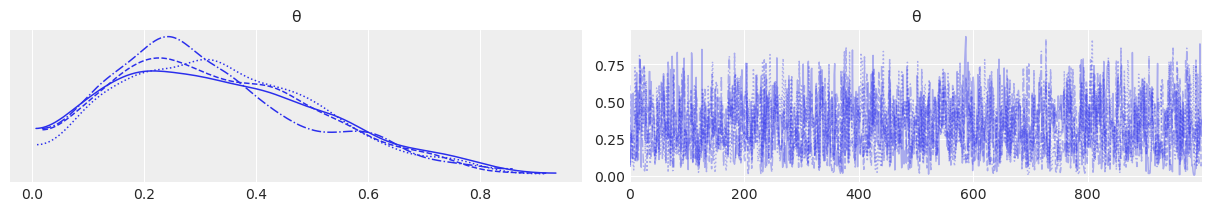

In [6]:
with our_first_model:
    az.plot_trace(trace)
# we get two subplot for each unobserved variable
# on the left we have Kernel Density Estimation (KDE)

In [7]:
with our_first_model:
    az_sum = az.summary(trace)
az_sum
# get numerical summary
# mean, sd standard deviation, 94% HPD interval (hpd3% and hpd 97%) highest posterior density, according to our data and model
# we think the parameter in question is between hpd 3% and hpd 97% with a probability of 94%

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
θ  0.332  0.18   0.016     0.65      0.005    0.003    1418.0    1928.0    1.0

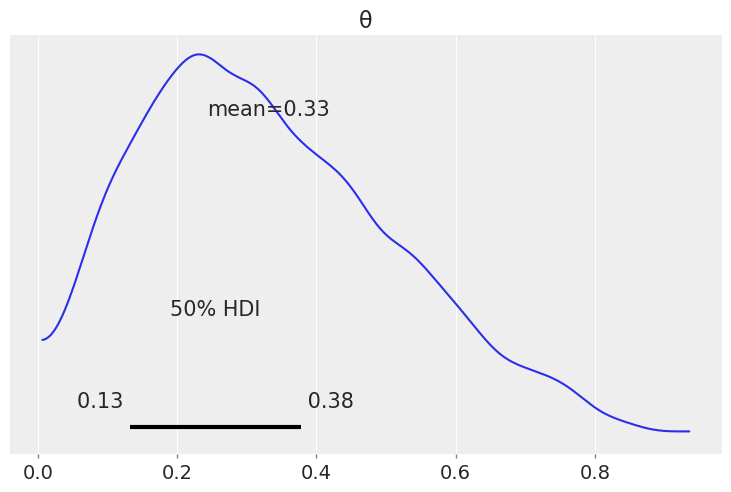

In [8]:
with our_first_model:
    az.plot_posterior(trace, hdi_prob=0.5)
plt.savefig('B11197_02_02.png', dpi=300)
# HDI is the interval that contains points that have higher probability density than points lying outside it
# credible interval capture the uncertainty in the location of the parameter values and thus can be interpreted as the probabilistic statement about the parameter

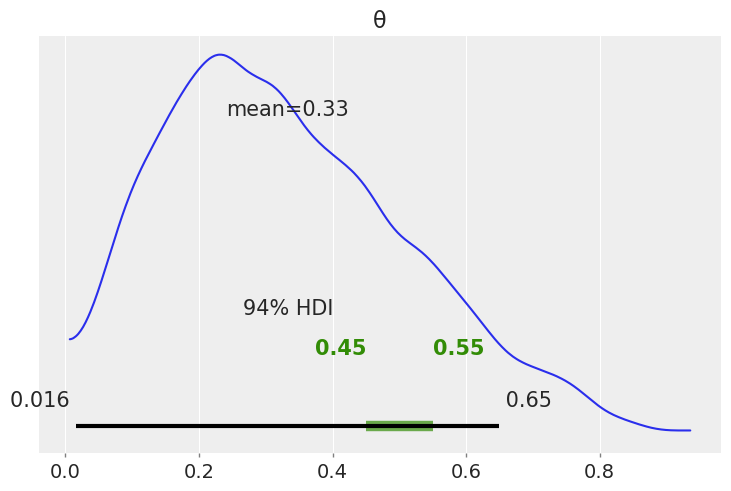

In [9]:
with our_first_model:
    az.plot_posterior(trace, rope=[0.45,0.55]) #rope = region of practical equivalence

# we can get 3 scenarios:
# ROPE does not overlop HDI => the coin is not fair
# ROPE contains the entire HDI => the coin is fair
# ROPE overlap HDI => cwe cannot say if yes or no the coin is fair

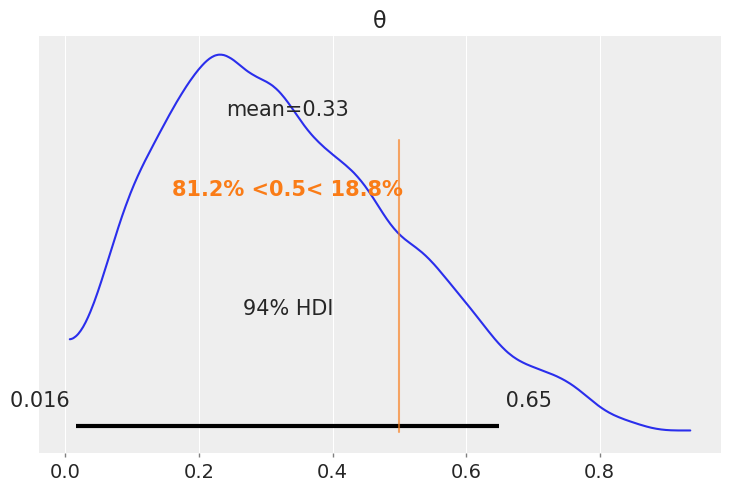

In [10]:
with our_first_model:
    az.plot_posterior(trace, ref_val=0.5) #reference value

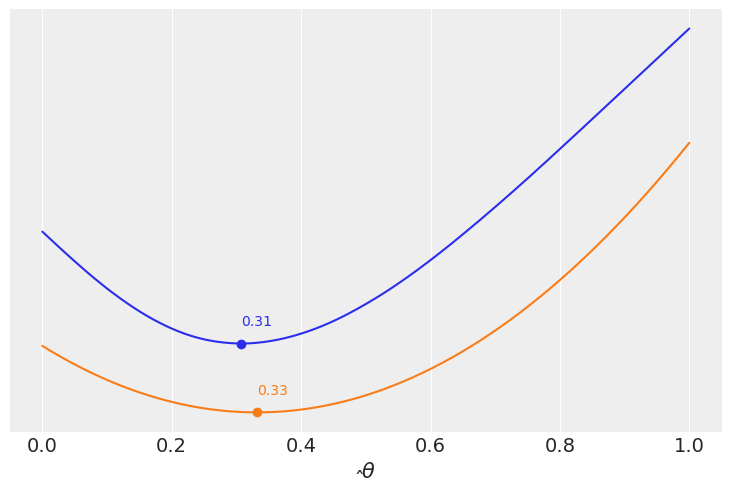

In [11]:
# instead of ROPE or Ref_val we can calculate the loss function, which represent the difference between the true and the estimated value of the parameter
# as we don't usually have the true value at hand and we know that theta is between 0 and 1 we will compute the loss function
# with [0, 1] and the posterior distribution of theta
grid = np.linspace(0, 1, 200) #200 points
θ_pos = trace['θ']   # 2000 elements or points
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid] # 200 elements absolute loss
lossf_b = [np.mean((i - θ_pos)**2) for i in grid] # 200 elements quadratic loss

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']): # The zip() function takes iterables (can be zero or more), aggregates them in a tuple, and returns it.
    mini = np.argmin(lossf, axis=0)  # return the indice of a minimum along an axis here the axis is the column by default
    plt.plot(grid, lossf, c)  # plot both loss function 
    plt.plot(grid[mini], lossf[mini], 'o', color=c) # plot the minimum
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_05.png', dpi=300)

In [12]:
trace['θ'].size

4000

In [13]:
grid.size

200

In [14]:
len(lossf_a)

200

In [15]:
np.mean(θ_pos) #quadratic loss

0.3318337027733495

In [16]:
np.median(θ_pos) #absolute loss

0.30799294352838047

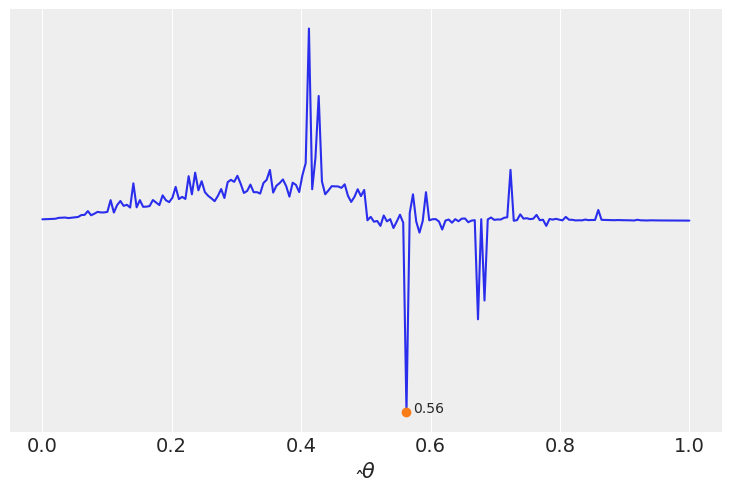

In [17]:
lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_06.png', dpi=300)

## Gaussian all the way down

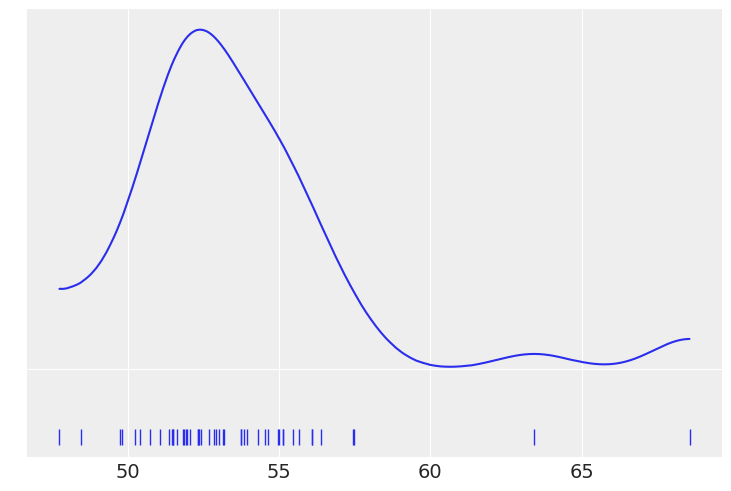

In [47]:
data = np.loadtxt("C:/Users/kamguia_l/Documents/data/chemical_shifts.csv")

# remove outliers using the interquartile rule
#quant = np.percentile(data, [25, 75])
#iqr = quant[1] - quant[0]
#upper_b = quant[1] + iqr * 1.5
#lower_b = quant[0] - iqr * 1.5
#data = data[(data > lower_b) & (data < upper_b)]
#print(np.mean(data), np.std(data))

az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)
plt.savefig('B11197_02_07.png', dpi=300)

In [48]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_13992/2533556942.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_g = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.


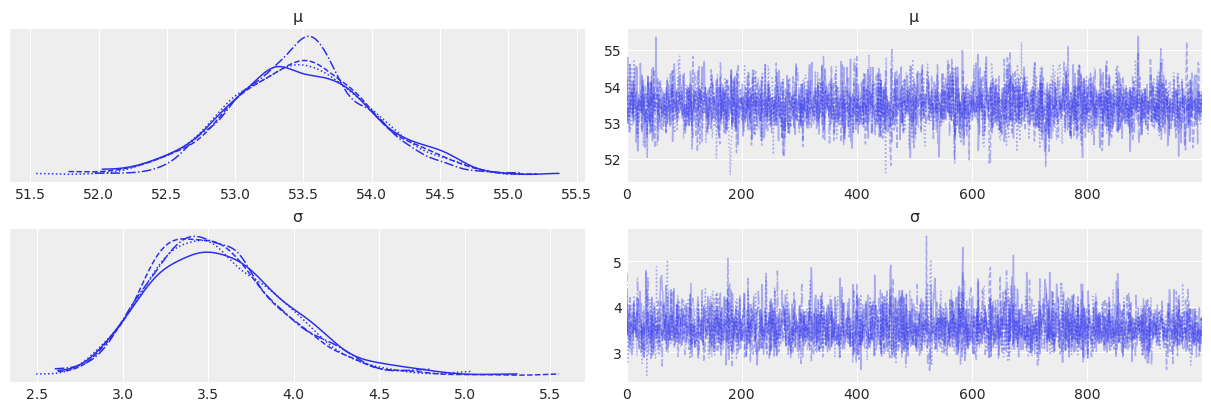

In [49]:
with model_g:
    az.plot_trace(trace_g)
plt.savefig('B11197_02_09.png', dpi=300)

D:\Anaconda\lib\site-packages\arviz\plots\jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


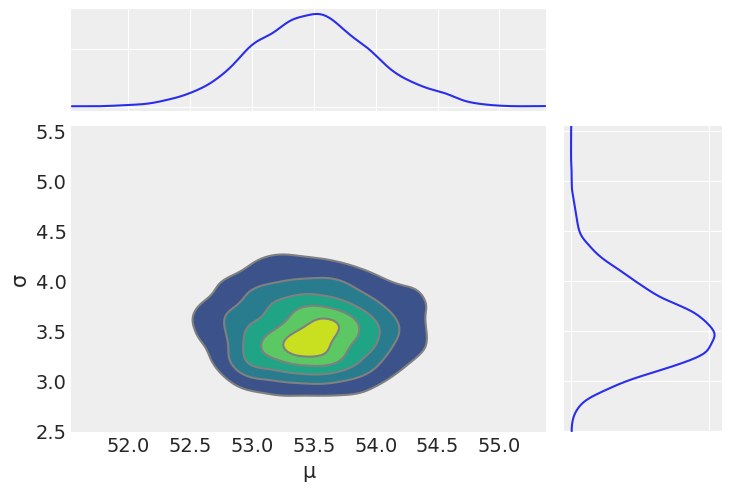

In [50]:
# this is to plot a bidimensional post terior that means combine the marginal distribution
with model_g:
    az.plot_joint(trace_g, kind='kde', fill_last=False)
    #az.plot_pair(trace_g, kind='kde')
plt.savefig('B11197_02_10.png', dpi=300)

In [51]:
with model_g:
    model_g_sum =az.summary(trace_g)
model_g_sum

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.479  0.512  52.576   54.533      0.009    0.006    3398.0    2364.0   
σ   3.550  0.383   2.872    4.242      0.007    0.005    3375.0    2471.0   

   r_hat  
μ    1.0  
σ    1.0

<AxesSubplot:>

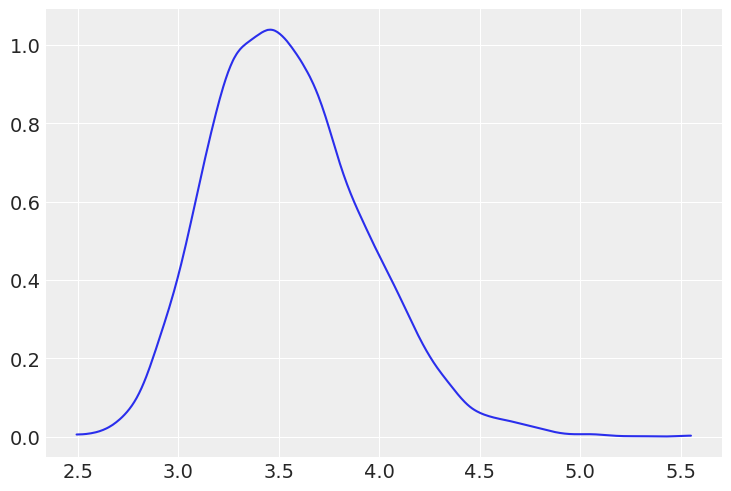

In [52]:
az.plot_kde(trace_g['σ'])

<AxesSubplot:>

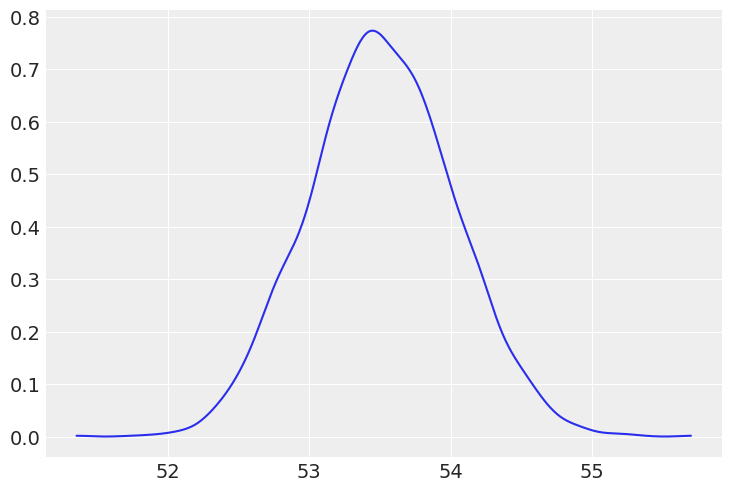

In [24]:
az.plot_kde(trace_g['μ'])

  Posteriror Predictive Check

In [25]:
# we are geting posterior predictive samples with the function below
# we get a dictionnary with keys equal the name of variable and value an array of shape (samples, size)
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

D:\Anaconda\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [26]:
len(data)

48

In [27]:
y_pred_g.keys()

dict_keys(['y'])

In [28]:
y_pred_g['y'][0]

array([46.54582489, 57.3966731 , 54.13139397, 42.8779526 , 52.51599486,
       53.06494538, 54.73922199, 60.70656115, 57.44537658, 52.28588199,
       51.78882773, 53.89282179, 51.72922373, 56.52644699, 51.09745533,
       56.05277784, 54.36728031, 50.00180422, 53.10804164, 52.88719562,
       55.62503817, 48.3332013 , 56.65998865, 56.09803299, 51.90219911,
       55.06163059, 53.91627918, 51.01069047, 54.21539293, 52.11401056,
       54.9317553 , 52.16881878, 49.66737978, 57.6230411 , 57.85315675,
       57.81783328, 54.02161881, 55.13316178, 47.7413468 , 50.67315876,
       53.21535767, 49.81462552, 59.36323569, 54.61526463, 52.3350403 ,
       56.65502748, 53.63210911, 49.54435518])

In [29]:
y_pred_g.values()

dict_values([array([[46.54582489, 57.3966731 , 54.13139397, ..., 56.65502748,
        53.63210911, 49.54435518],
       [47.72668125, 52.78197636, 53.57385485, ..., 50.34235853,
        53.65625939, 53.95866202],
       [54.9210596 , 50.60480283, 50.19808963, ..., 52.27445847,
        51.39635347, 47.38618604],
       ...,
       [57.8834768 , 54.08102002, 55.41498208, ..., 50.3943372 ,
        48.42909671, 54.71945752],
       [59.18675163, 56.76560678, 54.59593537, ..., 52.7648035 ,
        52.38618564, 53.53681766],
       [55.57096521, 52.70352638, 57.83545007, ..., 48.53685707,
        51.47889595, 50.33371567]])])

posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


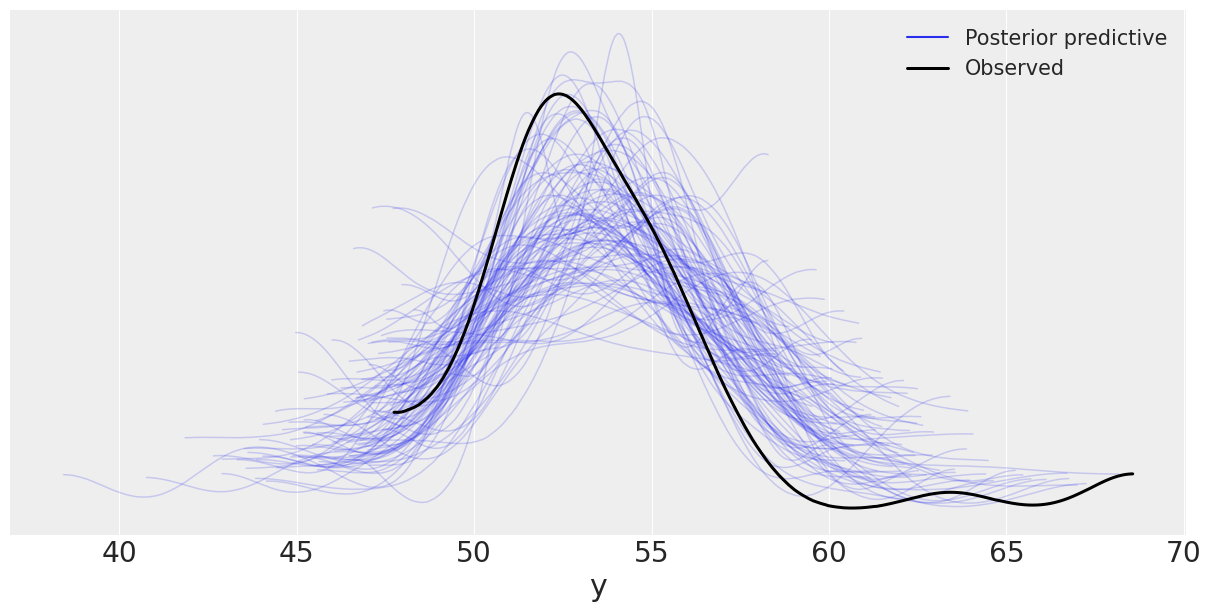

In [36]:
# we use plot_ppc for posterior predictive check
with model_g:
    data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax.legend(fontsize=15)
plt.savefig('B11197_02_11.png', dpi=300)

## Robust inference

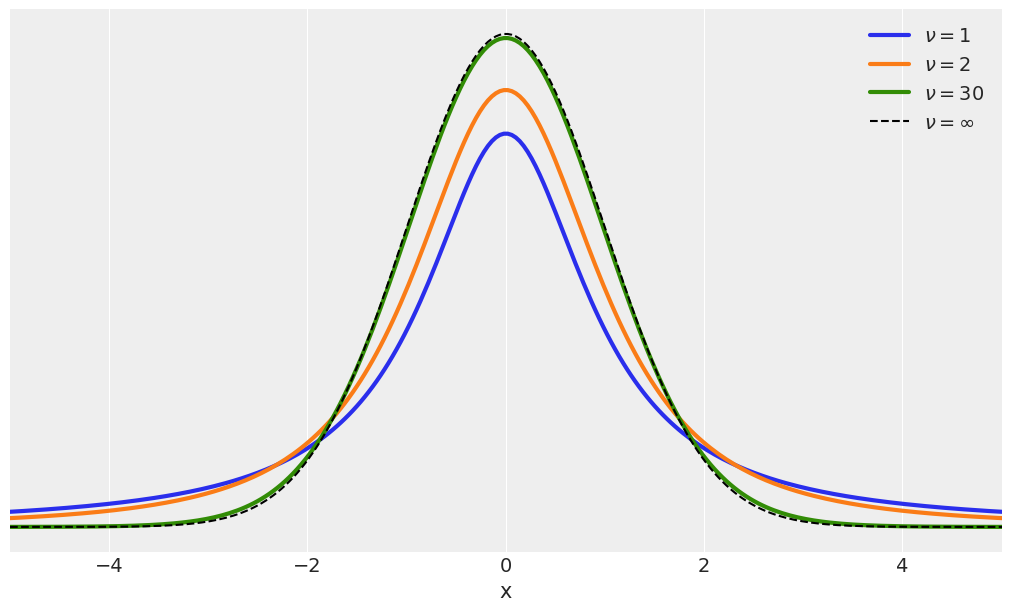

In [58]:
# we can replace the gaussian distribution with the T-student distribution, it has 3 parameters: mean, scale (analogous to the standard deviation),
# the degree of freedom also called the normality parameter.
# when df is <=1 the it has no mean define
# when df <= 2 it has no variance hence no standard deviation
# when df ~ infinity mean = standard deviation
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)
plt.savefig('B11197_02_12.png', dpi=300)

In [59]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_13992/2368772525.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_t = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


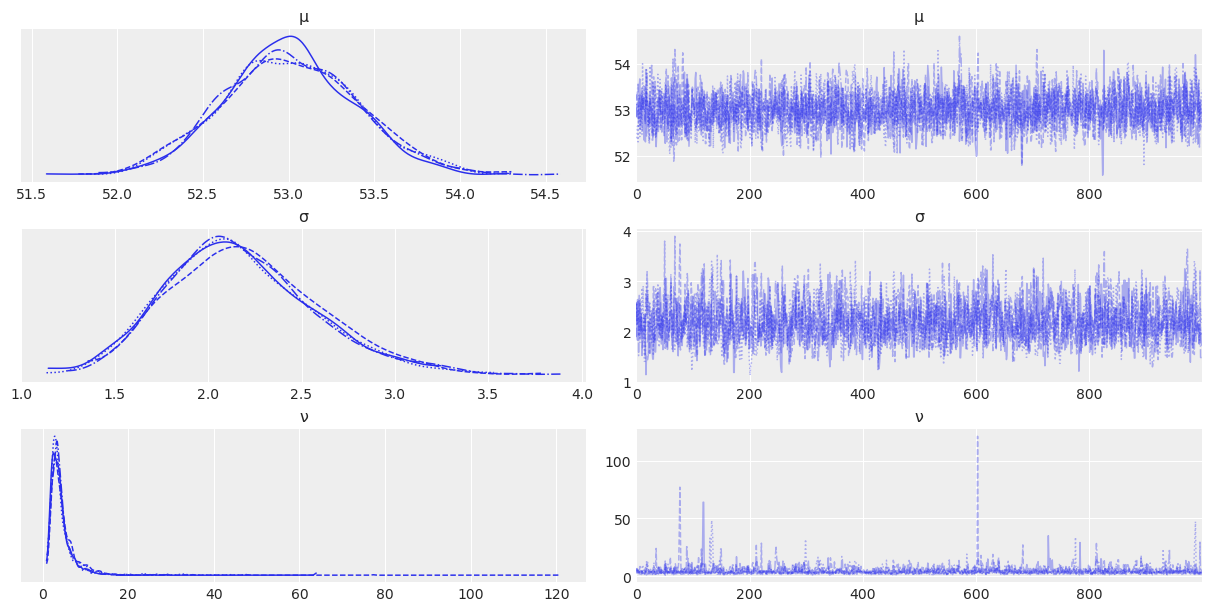

In [60]:
with model_t:
    az.plot_trace(trace_t)
plt.savefig('B11197_02_14.png', dpi=300)

In [61]:
with model_t:
    trace_t_sum=az.summary(trace_t)
trace_t_sum

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.007  0.388  52.305   53.773      0.007    0.005    2802.0    2469.0   
σ   2.179  0.393   1.484    2.937      0.010    0.007    1530.0    1908.0   
ν   4.550  4.242   1.102    9.668      0.104    0.073    1860.0    2104.0   

   r_hat  
μ    1.0  
σ    1.0  
ν    1.0

D:\Anaconda\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


AttributeError: 'numpy.ndarray' object has no attribute 'legend'

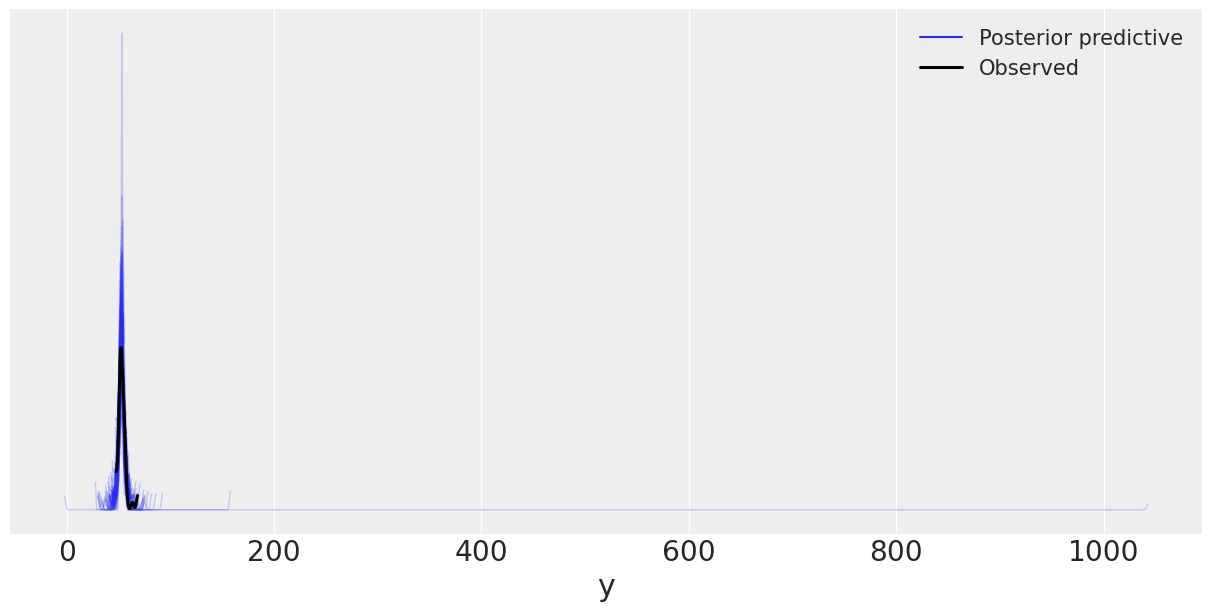

In [62]:
# we use plot_ppc for posterior predictive check
with model_t:
    y_ppc_t = pm.sample_posterior_predictive(trace_t, 100, model_t, random_seed=123)
    y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
ax.legend(fontsize=15)
plt.xlim(40, 70)
plt.savefig('B11197_02_15.png', dpi=300)

# Groups comparison

In [44]:
# statistical significance is different from practical significance
# a small effect can be declared significant just by collecting enough data
# the idea of hypothesis testing is connected to the concept of p-values that is sometimes misinterpreted even by statistician or people using it daily
# so instead of doing hypothesis testing we will focus on effect size that is quantifying the difference between two groups
# rather than question like does is work? we will ask how well does it work?


# by doing so we will estimate posterior distribution of the difference instead of point estimation
# we use three tools: 
# - posterior plot with refernce value  az.plot_posterior(trace, ref_value)
# - cohen's d a way to measure the effect size, where the difference of the means are standardized by considering the pooled standard deviations of both groups
# - probability of superiority

## Tips Example

In [4]:
# tips is data on restaurant
# we are interested with the effect of day (groups) on the amount of tips (pourboire)
tips = pd.read_csv('C:/Users/kamguia_l/Documents/data/tips.csv')
tips.tail()

total_bill   tip     sex smoker   day    time  size
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

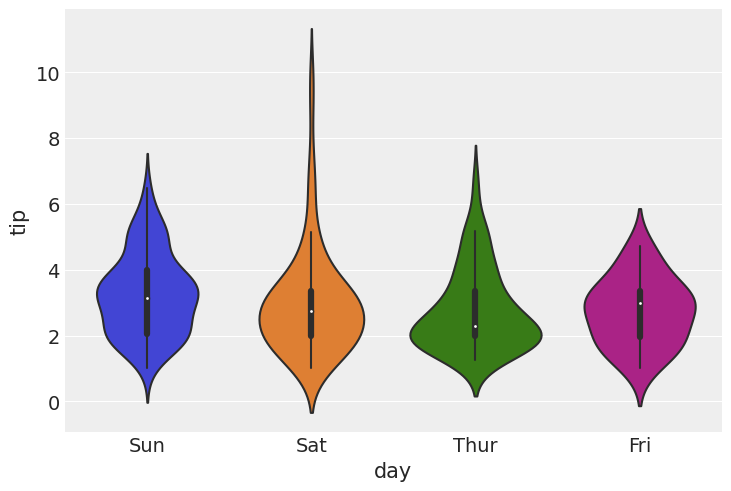

In [5]:
sns.violinplot(x='day', y='tip', data=tips)
plt.savefig('B11197_02_16.png', dpi=300)

In [6]:
pd.Categorical(tips['day'], categories=['Thur', 'Fri', 'Sat', 'Sun']).codes

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0], dtype=int8)

In [7]:
tip = tips['tip'].values #produce an array that contain all data (value) of tip
idx = pd.Categorical(tips['day'], categories=['Thur', 'Fri', 'Sat', 'Sun']).codes # an array with the category as value
groups = len(np.unique(idx)) # contains the scalar 4 for 4 groups

In [8]:
len(np.unique(idx))

4

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_13992/2241339191.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_cg = pm.sample(5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 93 seconds.


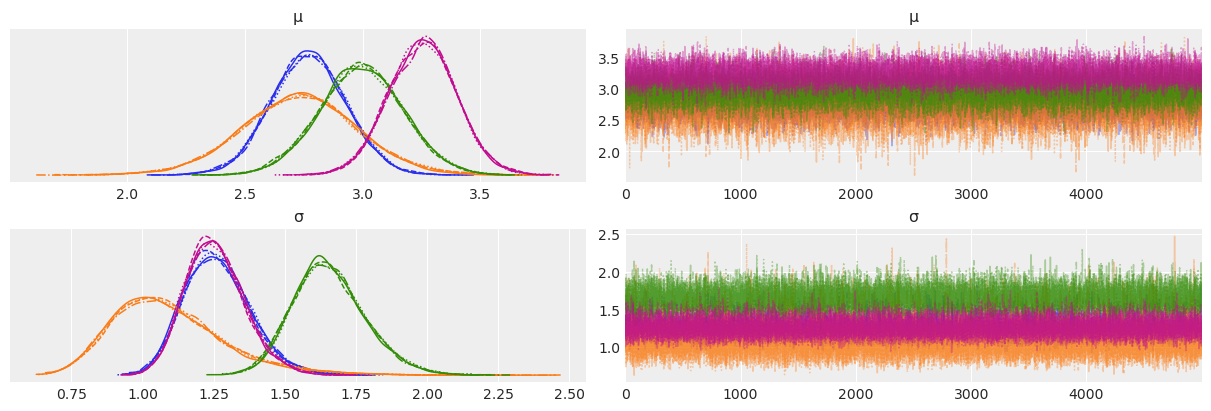

In [9]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)
    trace_cg = pm.sample(5000)
    
with comparing_groups:
    az.plot_trace(trace_cg)
plt.savefig('B11197_02_17.png', dpi=300)

In [10]:
x=range(3)
x

range(0, 3)

In [11]:
idx

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0], dtype=int8)

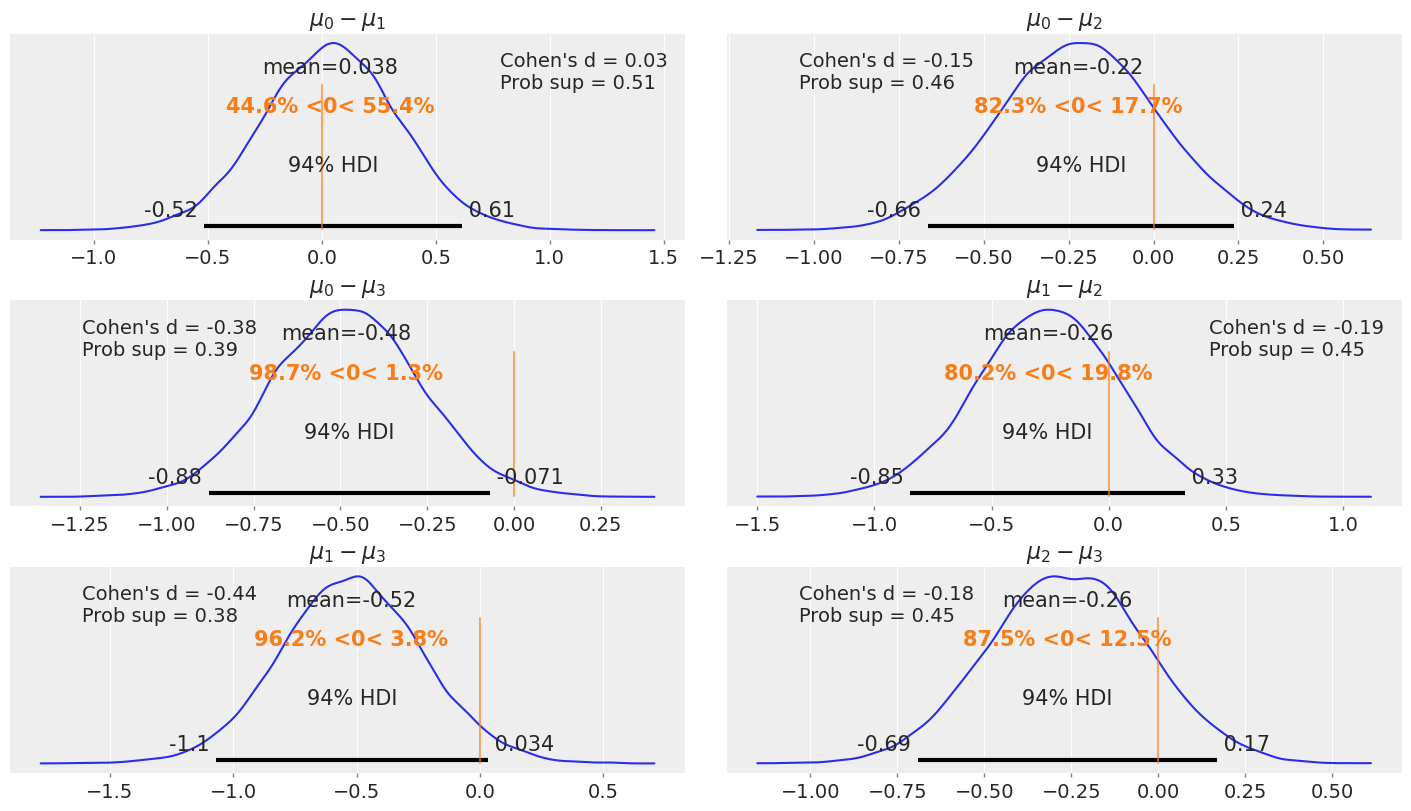

In [54]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()
plt.savefig('B11197_02_18.png', dpi=300)

## Hierachical Model

In [19]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]  # [3, 3, 3]  [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [20]:
group_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [21]:
data

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [22]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    trace_h = pm.sample(2000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_13992/3060014468.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_h = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 111 seconds.


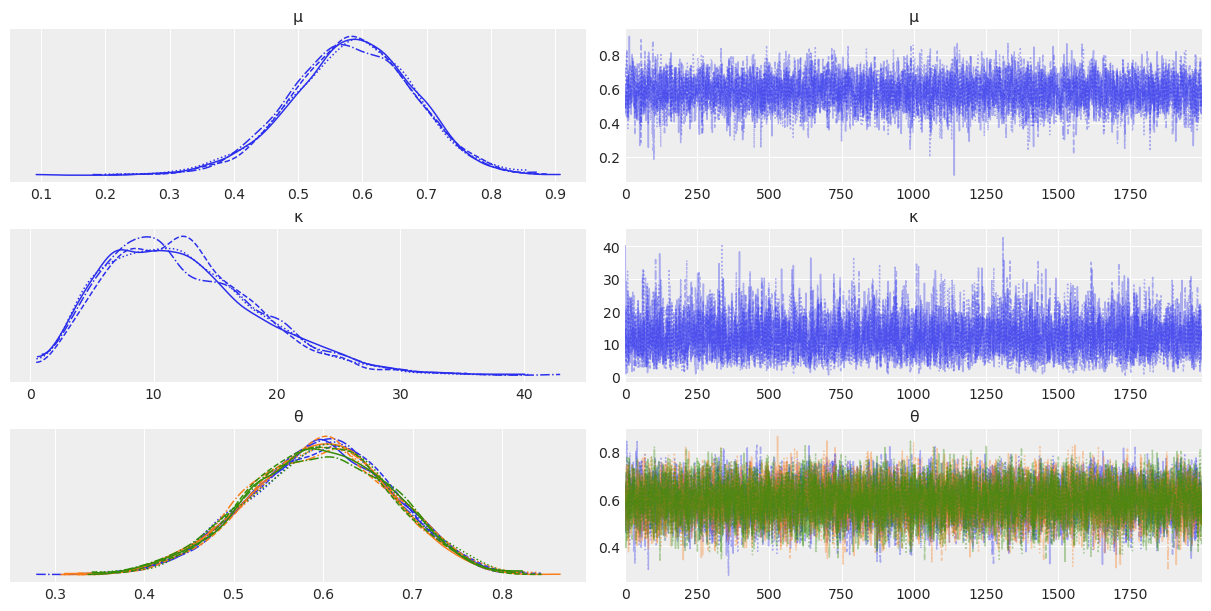

In [23]:
with model_h:
    az.plot_trace(trace_h)
plt.savefig('B11197_02_20.png', dpi=300)

In [24]:
with model_h:
    model_h_sum=az.summary(trace_h)
model_h_sum

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ      0.584  0.095   0.397    0.755      0.001    0.001    5555.0    5282.0   
κ     12.276  6.133   1.872   23.360      0.078    0.055    5708.0    4952.0   
θ[0]   0.597  0.079   0.454    0.746      0.001    0.001    5803.0    5759.0   
θ[1]   0.595  0.079   0.443    0.740      0.001    0.001    6069.0    5543.0   
θ[2]   0.595  0.080   0.453    0.751      0.001    0.001    6114.0    5778.0   

      r_hat  
μ       1.0  
κ       1.0  
θ[0]    1.0  
θ[1]    1.0  
θ[2]    1.0

# shrinkage

In [61]:
# shrinkage provide the ability to a model when we specify an hyper prior to communicate between different group
# at the end it is not a modelisation on a big group neither of differents independant group rather in the middle
# where communication is allowed

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_6220/34349557.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_ha = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ      0.585  0.095   0.411    0.765      0.001    0.001    4723.0    5320.0   
κ     12.424  6.125   2.106   23.689      0.078    0.056    5797.0    4891.0   
θ[0]   0.597  0.078   0.455    0.747      0.001    0.001    5427.0    5255.0   
θ[1]   0.595  0.080   0.448    0.748      0.001    0.001    5727.0    5028.0   
θ[2]   0.597  0.081   0.442    0.744      0.001    0.001    5007.0    4989.0   

      r_hat  
μ       1.0  
κ       1.0  
θ[0]    1.0  
θ[1]    1.0  
θ[2]    1.0

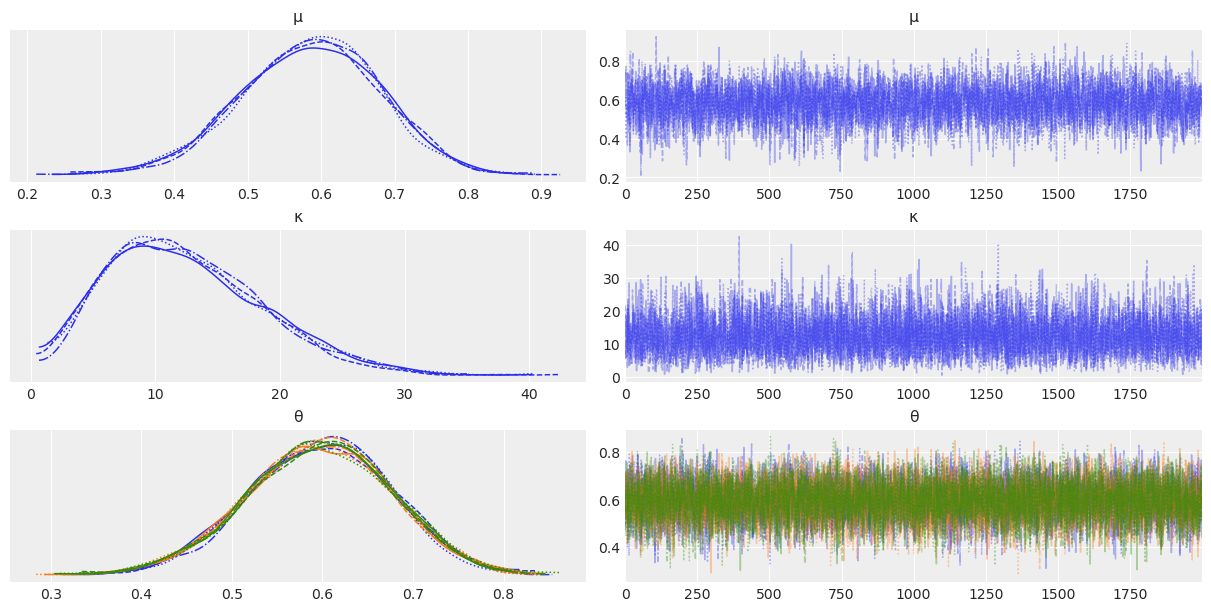

In [62]:
# all element of G_samples = 18

N_samples = [30, 30, 30]
G_samples_a = [18, 18, 18]  # [3, 3, 3]  [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data_a = []
for i in range(0, len(N_samples)):
    data_a.extend(np.repeat([1, 0], [G_samples_a[i], N_samples[i]-G_samples_a[i]]))


with pm.Model() as model_ha:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data_a)

    trace_ha = pm.sample(2000)
    
with model_ha:
    az.plot_trace(trace_ha)
    
with model_ha:
    model_ha_sum=az.summary(trace_ha)
model_ha_sum


C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_6220/35389938.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_hb = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ      0.163  0.076   0.039    0.291      0.001    0.001    5049.0    4952.0   
κ     11.655  6.217   1.289   22.843      0.082    0.058    5008.0    3979.0   
θ[0]   0.114  0.051   0.026    0.207      0.001    0.000    5854.0    4553.0   
θ[1]   0.114  0.052   0.025    0.210      0.001    0.001    4481.0    3602.0   
θ[2]   0.114  0.052   0.031    0.214      0.001    0.000    5270.0    3770.0   

      r_hat  
μ       1.0  
κ       1.0  
θ[0]    1.0  
θ[1]    1.0  
θ[2]    1.0

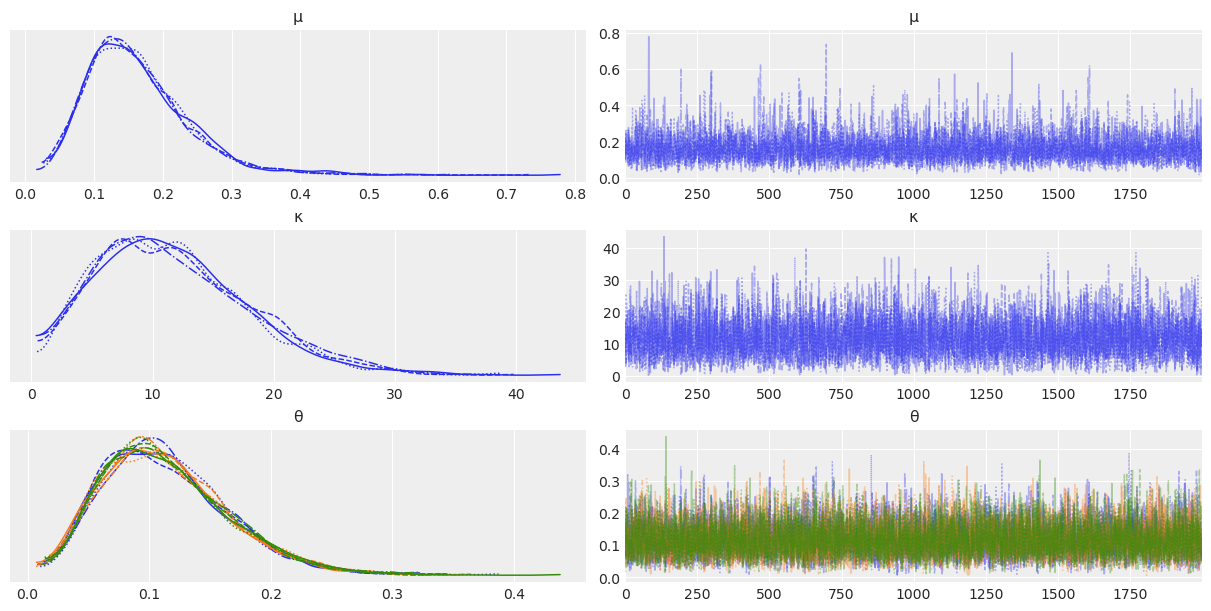

In [63]:
# all element of G_samples = 3

N_samples = [30, 30, 30]
G_samples_b = [3, 3, 3]  # [3, 3, 3]  [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data_b = []
for i in range(0, len(N_samples)):
    data_b.extend(np.repeat([1, 0], [G_samples_b[i], N_samples[i]-G_samples_b[i]]))


with pm.Model() as model_hb:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data_b)

    trace_hb = pm.sample(2000)
    
with model_hb:
    az.plot_trace(trace_hb)
    
with model_hb:
    model_hb_sum=az.summary(trace_hb)
model_hb_sum


C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_6220/3225693100.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_hc = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ     0.303  0.117   0.104    0.526      0.002    0.001    5147.0    5044.0   
κ     5.786  3.969   0.464   12.945      0.059    0.043    4697.0    4500.0   
θ[0]  0.552  0.091   0.382    0.720      0.001    0.001    6023.0    4799.0   
θ[1]  0.129  0.058   0.034    0.240      0.001    0.001    6143.0    5213.0   
θ[2]  0.128  0.058   0.030    0.235      0.001    0.001    5482.0    4785.0   

      r_hat  
μ       1.0  
κ       1.0  
θ[0]    1.0  
θ[1]    1.0  
θ[2]    1.0

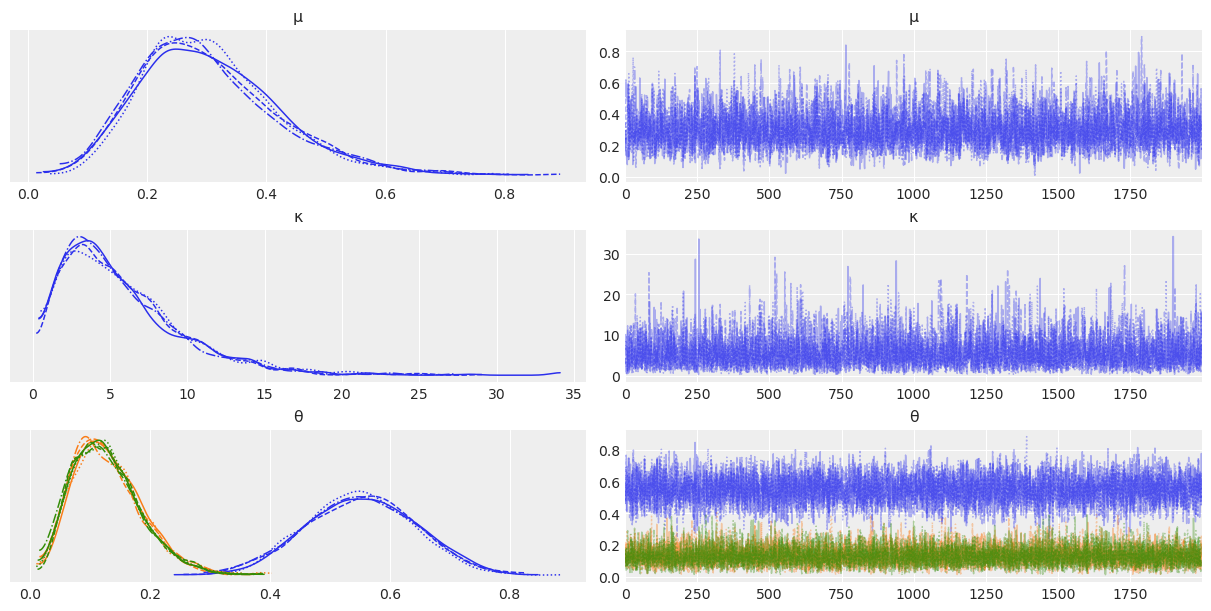

In [64]:
# one element of G_samples = 18 and the two others to 3

N_samples = [30, 30, 30]
G_samples_c = [18, 3, 3]  # [3, 3, 3]  [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data_c = []
for i in range(0, len(N_samples)):
    data_c.extend(np.repeat([1, 0], [G_samples_c[i], N_samples[i]-G_samples_c[i]]))


with pm.Model() as model_hc:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data_c)

    trace_hc = pm.sample(2000)
    
with model_hc:
    az.plot_trace(trace_hc)
    
with model_hc:
    model_hc_sum=az.summary(trace_hc)
model_hc_sum


In [65]:
len(trace_h)

2000

In [66]:
trace_h.varnames

['μ_logodds__', 'κ_log__', 'θ_logodds__', 'μ', 'κ', 'θ']

In [67]:
len(trace_h['μ'])

8000

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_6220/2827977034.py:19: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


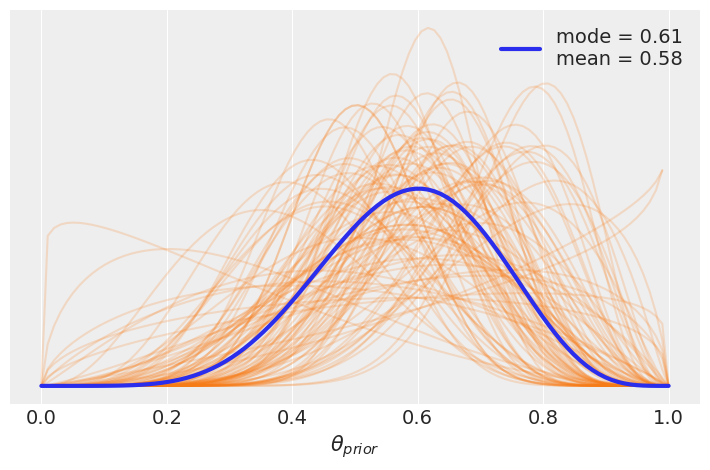

In [68]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    u = trace_h['μ'][i]
    k = trace_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = trace_h['μ'].mean()
k_mean = trace_h['κ'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()
plt.savefig('B11197_02_21.png', dpi=300)

In [69]:
cs_data = pd.read_csv('C:/Users/kamguia_l/Documents/data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

In [70]:
cs_data.tail()

ID   aa   theo    exp
1771  1KS9  LYS  55.79  57.51
1772  1KS9  ARG  58.91  59.02
1773  1KS9  LYS  59.49  58.92
1774  1KS9  GLU  59.48  58.36
1775  1KS9  SER  58.07  60.55

In [71]:
with pm.Model() as cs_nh:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_nh = pm.sample(1000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_6220/1361008268.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_cs_nh = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [72]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_h = pm.sample(1000)


C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_6220/3714075219.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_cs_h = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ, σ_μ, μ_μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


ValueError: not enough values to unpack (expected 2, got 1)

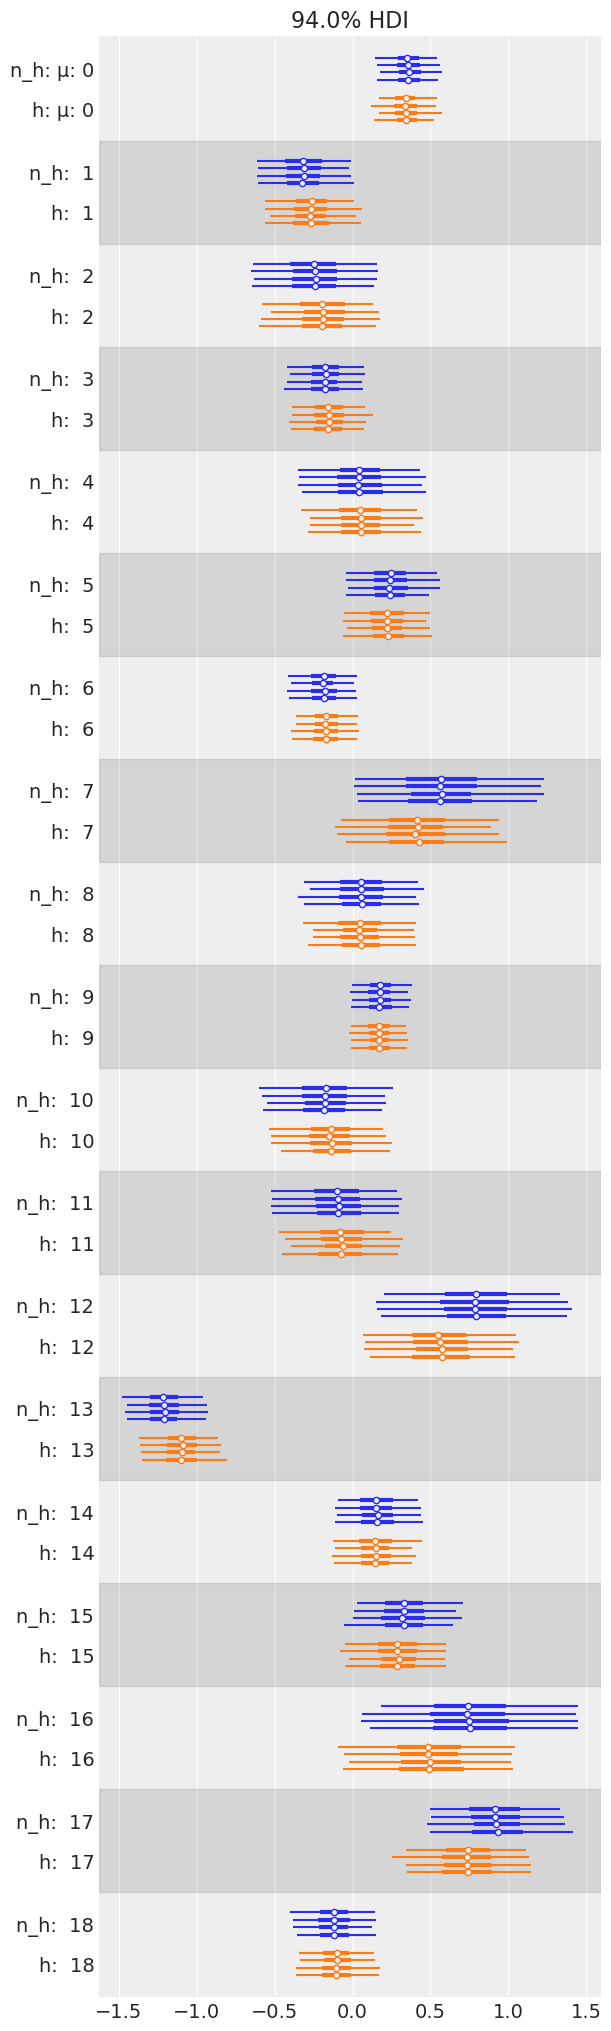

In [78]:
with cs_h, cs_nh:
    axes = az.plot_forest(data=[trace_cs_nh, trace_cs_h],
                         model_names=["n_h", "h"],
                         var_names="μ", combined=False, colors='cycle',  kind='forestplot')
    y_lims = axes[0].get_ylim()
    axes[0].vlines(trace_cs_h['μ_μ'].mean(), *y_lims)
plt.savefig('B11197_02_22.png', dpi=300)

### Exercices

In [79]:
np.random.seed(123)
trials =4
theta_real = 0.35 #unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)

In [80]:
with pm.Model() as our_first_model:
    # a priori
    θ = pm.Uniform('θ', lower=-1., upper=2.) 
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace_ex = pm.sample(1000, random_seed=123)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_6220/893895102.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_ex = pm.sample(1000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.


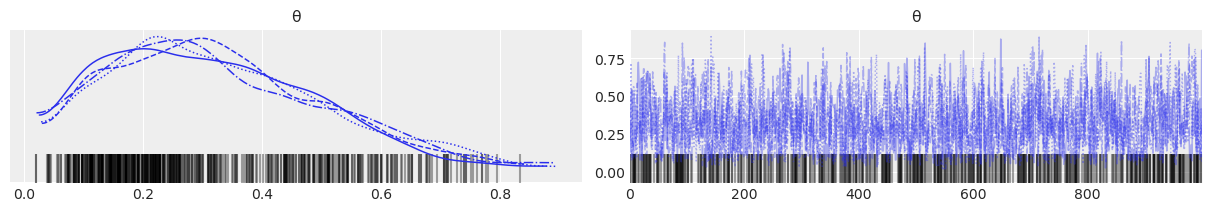

In [81]:
with our_first_model:
    az.plot_trace(trace_ex)

In [82]:
with our_first_model:
    trace_ex_sum=az.summary(trace_ex)
trace_ex_sum

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
θ  0.323  0.173   0.037    0.628      0.005    0.003    1426.0    1942.0   

   r_hat  
θ    1.0

### Coal Mining Disaster

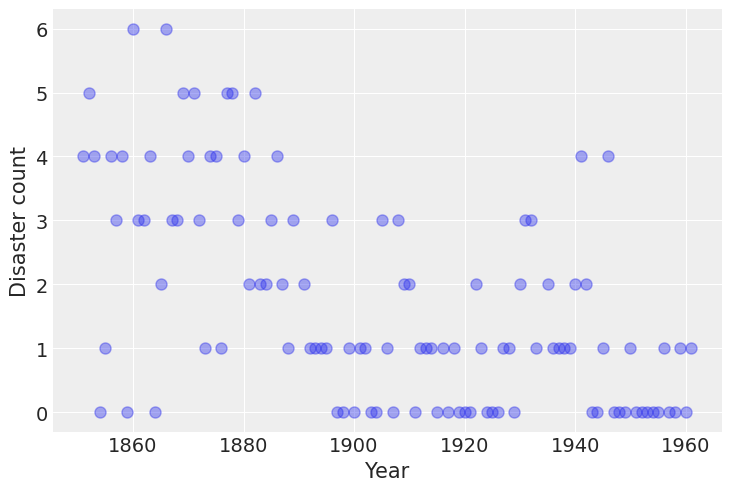

In [83]:
import pandas as pd

# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
) # here is the number of disaster observed each year between 1851 and 1962, some data are missing
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [84]:
# Dt is the number of disaster a year t, it follow a poisson process and we make hypothesis that it change after we had put in place some regulations
# rt the parameter of the process then has two value one before the regulation and one after that suppose we have a switchpoint
# s is the switch point it follow a uniform distribution it is between min and max year of the period of observation
# as the early and late rate stand during a period of time they follow an exponential distribution [durée de vie sans mémoireet sans viellissement au sens de l'usure]

with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max(), testval=1900) #switch point

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0) #exponential distribution
    late_rate = pm.Exponential("late_rate", 1.0) #exponential distribution

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate) #pm.math.switch a way to materialise the shift of rate

    disasters = pm.Poisson("disasters", rate, observed=disaster_data) #disaster itself follow a poisson distribution
    
    trace = pm.sample(10000, random_seed=1234)

D:\Anaconda\lib\site-packages\pymc3\model.py:1755: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_6220/154733426.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, random_seed=1234)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 50 seconds.
The number of effective samples is smaller than 10% for some parameters.


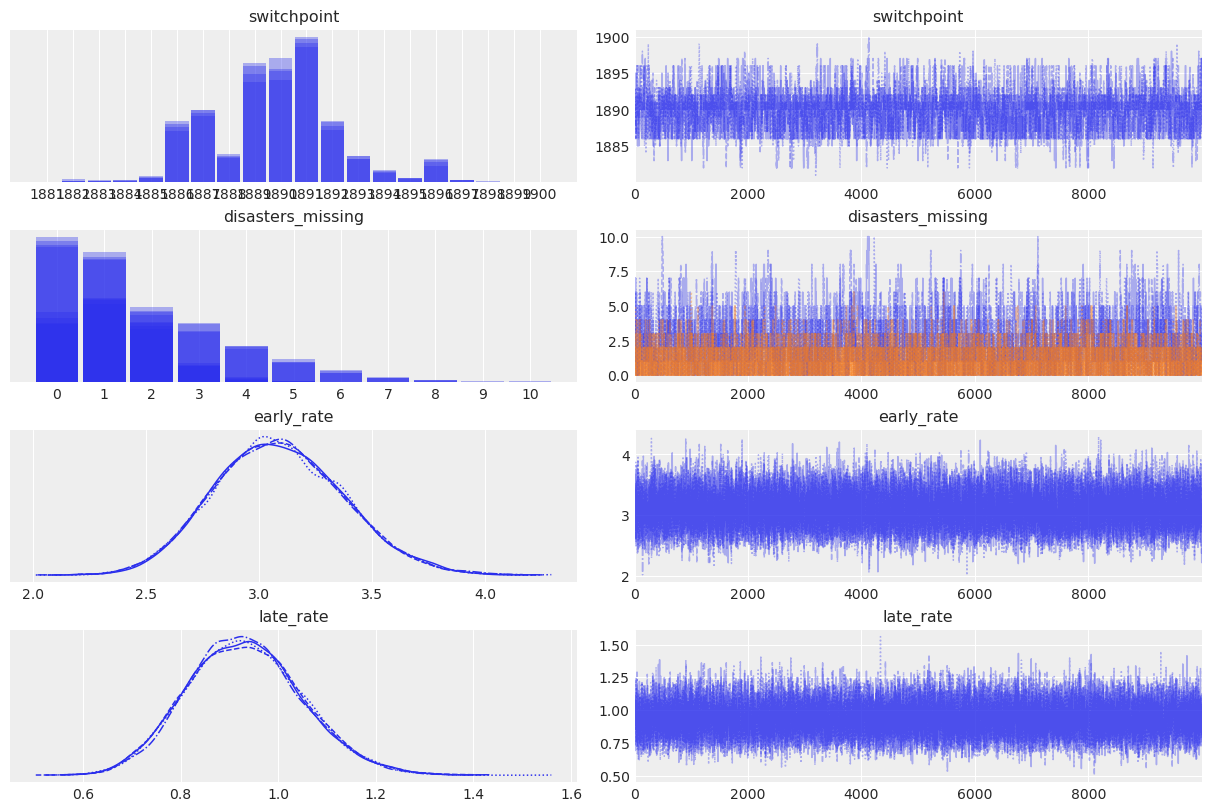

In [85]:
with disaster_model:
    az.plot_trace(trace)

In [86]:
with disaster_model:
    trace_sum =az.summary(trace)
trace_sum

mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
switchpoint           1889.812  2.438  1886.000  1894.000      0.052    0.037   
disasters_missing[0]     2.168  1.773     0.000     5.000      0.044    0.031   
disasters_missing[1]     0.903  0.953     0.000     3.000      0.014    0.010   
early_rate               3.089  0.286     2.568     3.638      0.002    0.001   
late_rate                0.932  0.118     0.711     1.151      0.001    0.001   

                      ess_bulk  ess_tail  r_hat  
switchpoint             2242.0    3921.0    1.0  
disasters_missing[0]    1647.0    3040.0    1.0  
disasters_missing[1]    5066.0    5412.0    1.0  
early_rate             20778.0   23161.0    1.0  
late_rate              20851.0   27012.0    1.0

In [87]:
with disaster_model:
    idata = az.from_pymc3(trace)

In [88]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

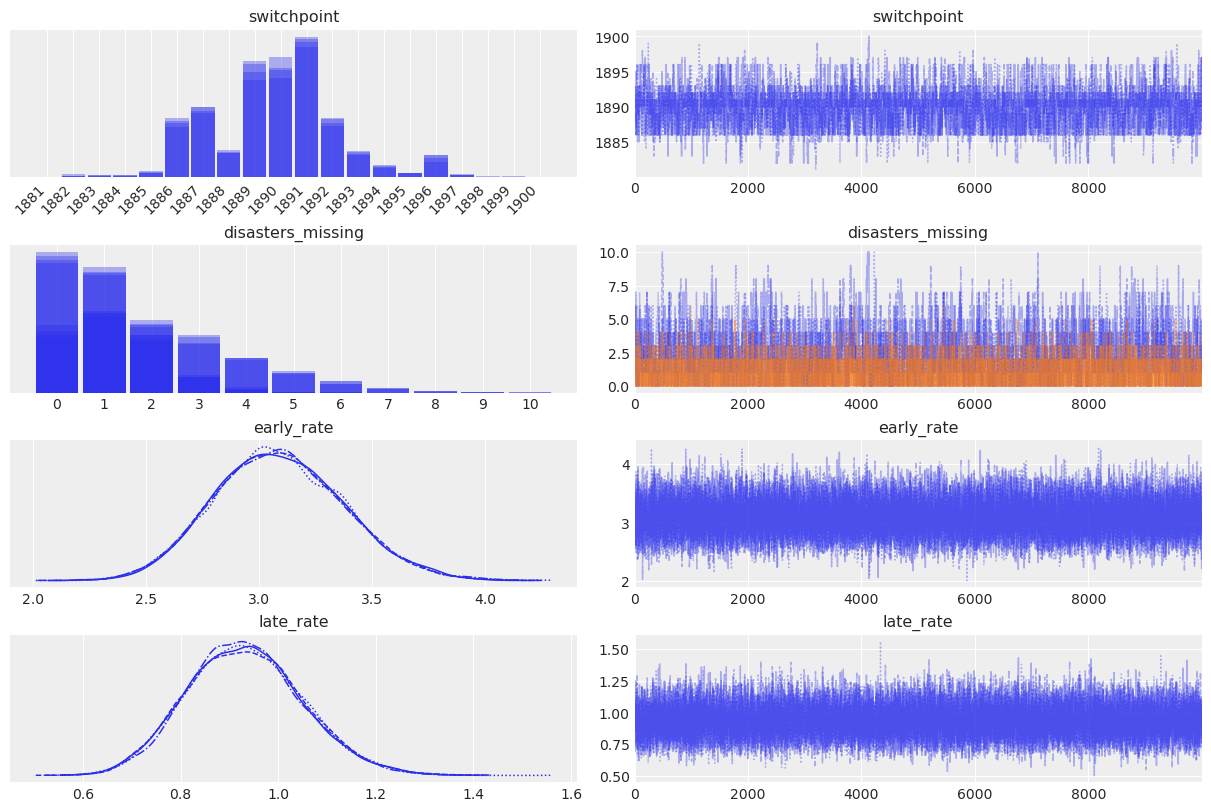

In [89]:
with disaster_model:
    axes_arr = az.plot_trace(trace)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

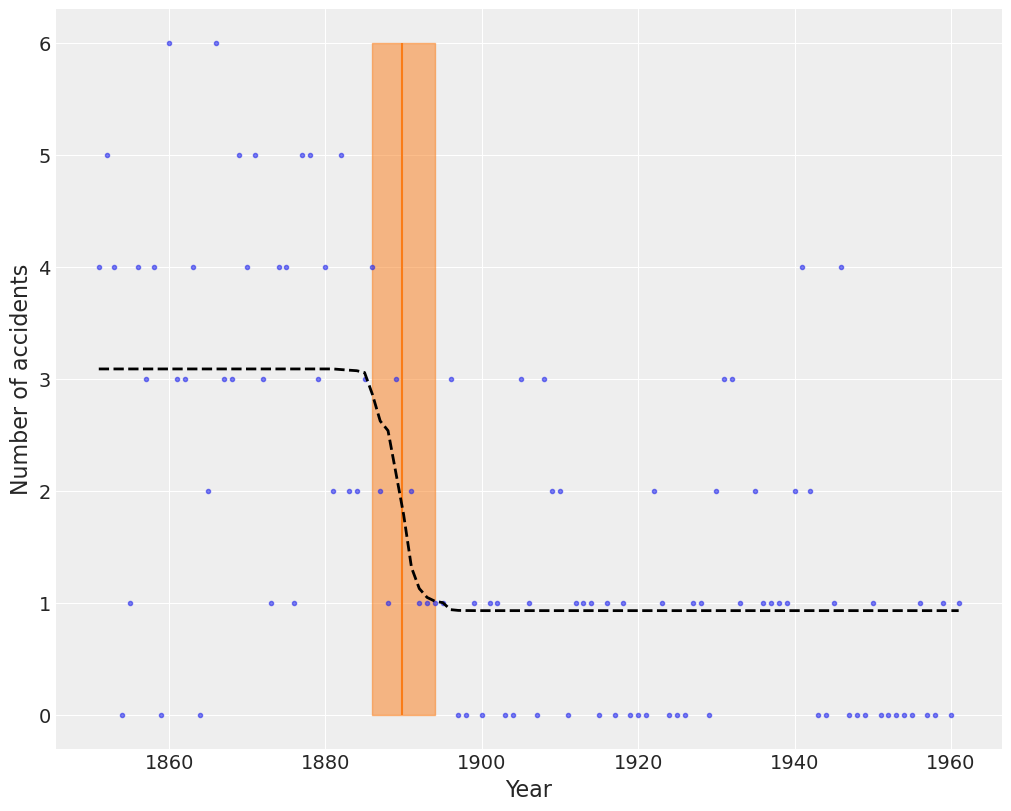

In [90]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(trace["switchpoint"])
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);

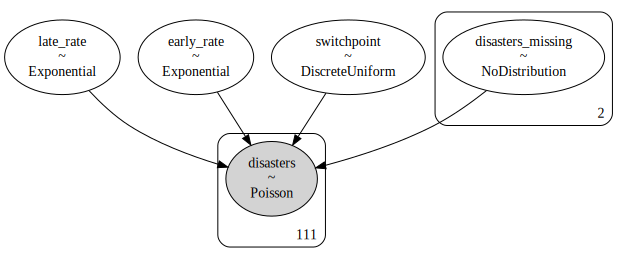

In [92]:
pm.model_to_graphviz(disaster_model)

In [93]:
11*1300/100

143.0

In [94]:
1300-143

1157

In [95]:
!pip3 install google

  Using cached google-3.0.0-py2.py3-none-any.whl (45 kB)


# Excercise 3

([<matplotlib.axis.YTick at 0x1ac553c0340>], [Text(0, 0, '')])

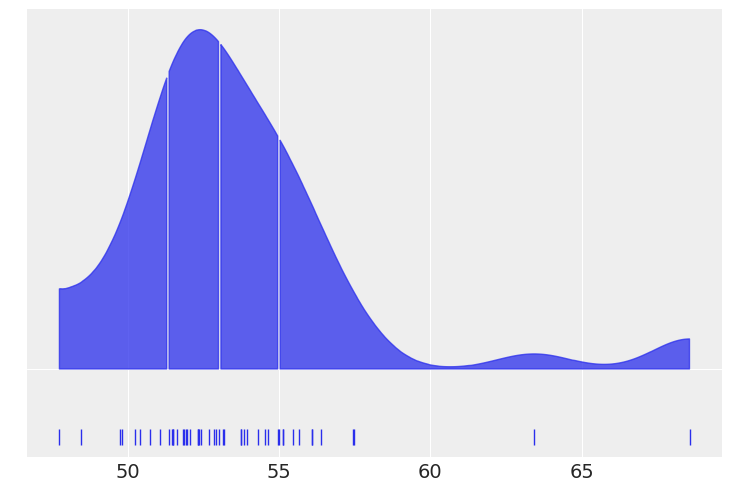

In [96]:
# modify model_g by changing the prior for the mean to a Gaussian distribution
# centered at the empirical mean, and play with a couple of reasonable values for
# the standard deviation of this prior.
# how robus/sensitive are the inferences to
# these changes? What do you think of using a Gaussian, which is an unbounded
# distribution (goes from -∞ to ∞), to model bounded data such as this? Remember
# that we said it is not possible to get values below 0 or above 100.

data = np.loadtxt('C:/Users/kamguia_l/Documents/data/chemical_shifts.csv')
az.plot_kde(data, rug=True, quantiles=[.25, .5, .75])
plt.yticks([0], alpha=0)

In [97]:
data.mean()

53.49645833333333

In [98]:
data.std()

3.4200063898474258

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_6220/4292457612.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_gm = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
D:\Anaconda\lib\site-packages\arviz\plots\jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


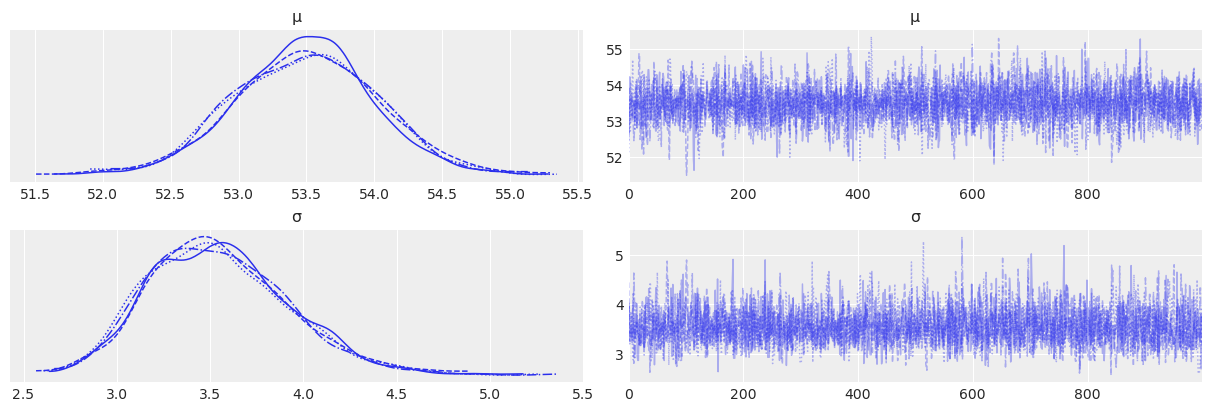

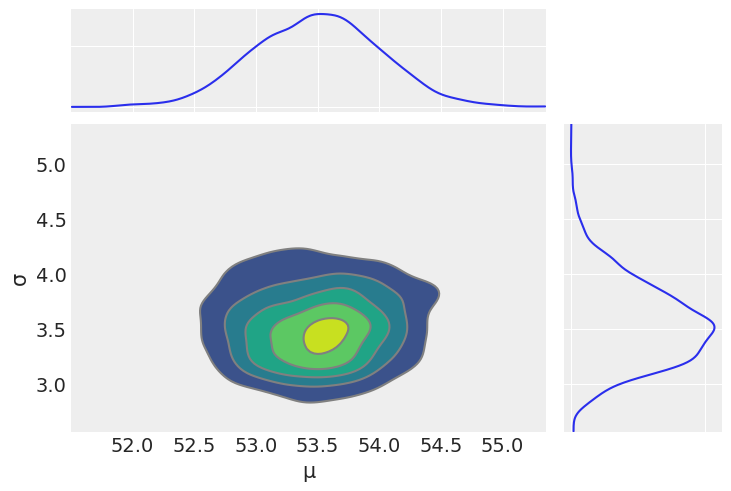

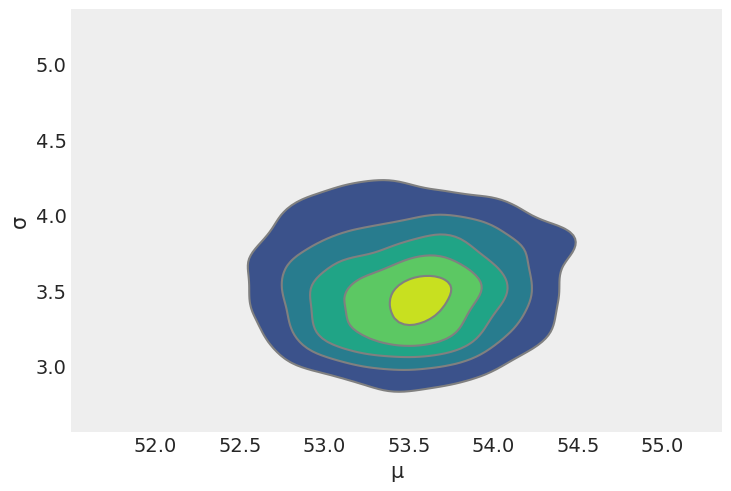

In [99]:
with pm.Model() as model_gm:
    μ = pm.Normal('μ', mu=53.5, sd=50)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_gm = pm.sample(1000)
with model_gm:
    az.plot_trace(trace_gm)
    az.plot_joint(trace_gm, kind='kde', fill_last=False)
    az.plot_pair(trace_gm, kind='kde')

In [100]:
with model_gm:
    trace_gm_sum=az.summary(trace_gm)
trace_gm_sum


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.493  0.521  52.504   54.435      0.009    0.006    3388.0    2475.0   
σ   3.549  0.376   2.897    4.258      0.007    0.005    3247.0    2592.0   

   r_hat  
μ    1.0  
σ    1.0

<AxesSubplot:>

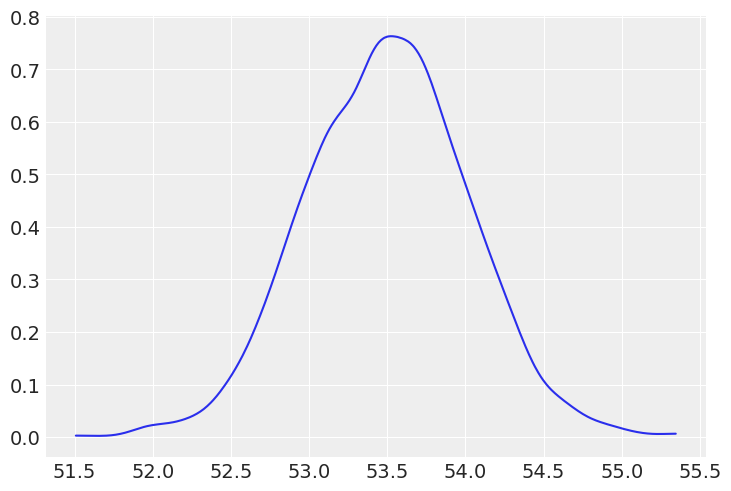

In [101]:
az.plot_kde(trace_gm['μ'])

<AxesSubplot:>

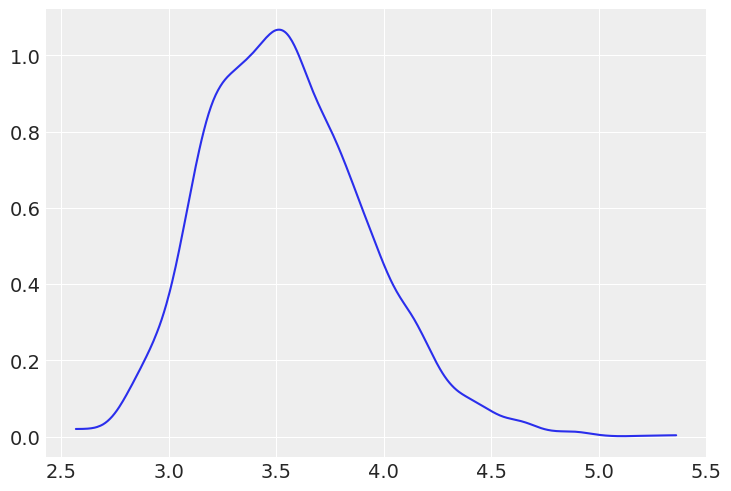

In [102]:
az.plot_kde(trace_gm['σ'])

In [103]:
# it is not too much sensitive, even when we take the std of mu = 50
# however it is still influence by outlier and give a std = 3.55 similar to the one of 3.54 with uniform prior

In [104]:
y_pred_gm = pm.sample_posterior_predictive(trace_gm, 100, model_gm) #produit 100 echantillons de chaque variable estimée composé de len(data) point

D:\Anaconda\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


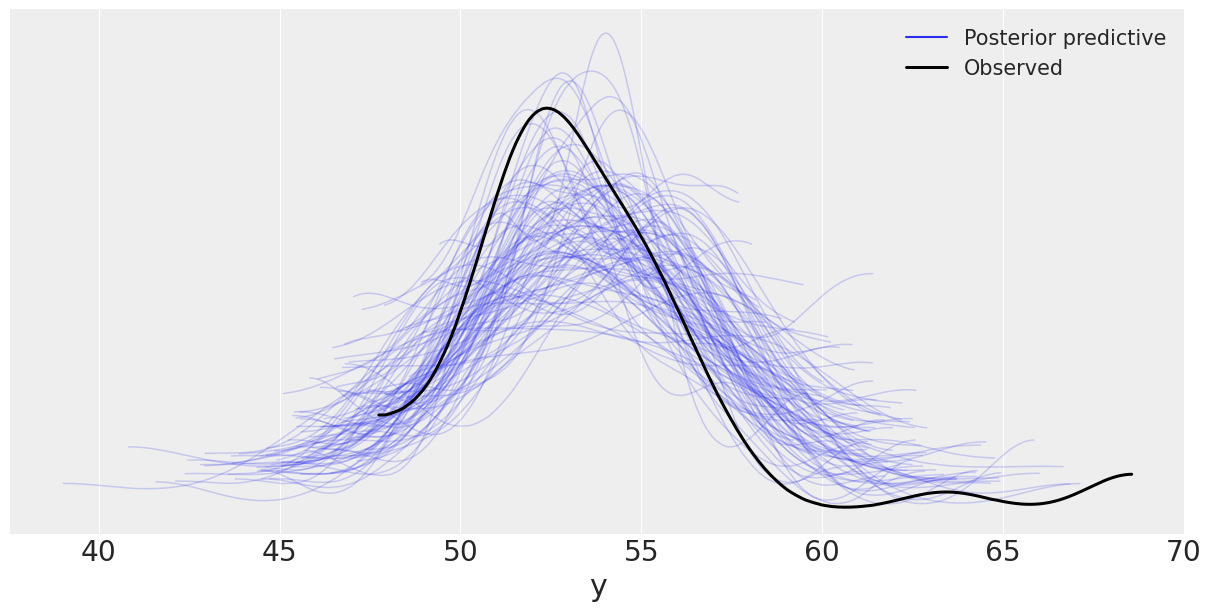

In [106]:
with model_gm:
    y_pred_tm = az.from_pymc3(trace=trace_gm, posterior_predictive=y_pred_gm)
    
ax = az.plot_ppc(y_pred_tm, figsize=(12,6), mean=False)
ax.legend(fontsize=15)

# Exercice 4

Using the data in the chemical_shifts.csv file, compute the empirical mean and the standard deviation with and without outliers. Compare those results to the Bayesian estimation using the Gaussian and Student's t-distribution. Repeat
the exercise by adding more outliers.

Without outliers:  52.95260869565218 2.1950303897892387
With outliers:  53.49645833333333 3.4200063898474258


([<matplotlib.axis.YTick at 0x20eaa0e23d0>], [Text(0, 0, '')])

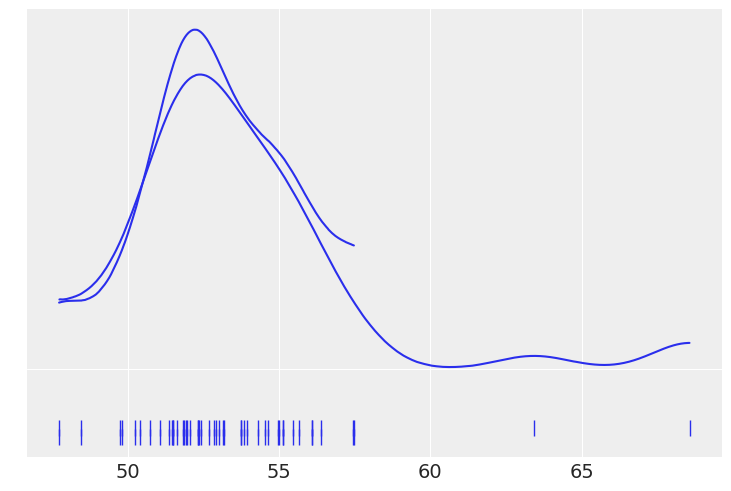

In [53]:
data = np.loadtxt("C:/Users/kamguia_l/Documents/data/chemical_shifts.csv")

# remove outliers using the interquartile rule
quant = np.percentile(data, [25, 75])
iqr = quant[1] - quant[0]
upper_b = quant[1] + iqr * 1.5
lower_b = quant[0] - iqr * 1.5
data_o = data[(data > lower_b) & (data < upper_b)]
print('Without outliers: ',np.mean(data_o), np.std(data_o))
print('With outliers: ',np.mean(data), np.std(data))

az.plot_kde(data, rug=True)
az.plot_kde(data_o, rug=True)
plt.yticks([0], alpha=0)

In [54]:
print('Without outliers: ',np.mean(data_o), np.std(data_o))


Without outliers:  52.95260869565218 2.1950303897892387


In [55]:

print('With outliers: ',np.mean(data), np.std(data))

With outliers:  53.49645833333333 3.4200063898474258


In [56]:
# Gaussian
az.summary(trace_g)

D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.479  0.512  52.576   54.533      0.009    0.006    3398.0    2364.0   
σ   3.550  0.383   2.872    4.242      0.007    0.005    3375.0    2471.0   

   r_hat  
μ    1.0  
σ    1.0

In [63]:
# t Student
az.summary(trace_t)

D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.007  0.388  52.305   53.773      0.007    0.005    2802.0    2469.0   
σ   2.179  0.393   1.484    2.937      0.010    0.007    1530.0    1908.0   
ν   4.550  4.242   1.102    9.668      0.104    0.073    1860.0    2104.0   

   r_hat  
μ    1.0  
σ    1.0  
ν    1.0

# Exercise 5

Modify the tips example to make it robust to outliers. Try with one shared v for all groups and also with one v per group. Run posterior predictive checks to
assess these three models.

In [65]:
# tips is data on restaurant
# we are interested with the effect of day (groups) on the amount of tips (pourboire)
tips = pd.read_csv('C:/Users/kamguia_l/Documents/data/tips.csv')
tips.tail()

total_bill   tip     sex smoker   day    time  size
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

In [66]:
tip = tips['tip'].values #produce an array that contain all data (value) of tip
idx = pd.Categorical(tips['day'], categories=['Thur', 'Fri', 'Sat', 'Sun']).codes # an array with the category as value
groups = len(np.unique(idx)) # contains the scalar 4 for 4 groups

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_13992/1121979312.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_cg = pm.sample(5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 35 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ[0]  2.770  0.159   2.454    3.056      0.001    0.001   21148.0   15716.0   
μ[1]  2.733  0.255   2.251    3.216      0.002    0.001   21464.0   14602.0   
μ[2]  2.992  0.179   2.659    3.327      0.001    0.001   25184.0   16559.0   
μ[3]  3.255  0.144   2.986    3.525      0.001    0.001   27899.0   16193.0   
σ[0]  1.266  0.118   1.056    1.494      0.001    0.001   23243.0   15264.0   
σ[1]  1.095  0.199   0.759    1.473      0.001    0.001   22648.0   15268.0   
σ[2]  1.654  0.127   1.427    1.903      0.001    0.001   25960.0   16147.0   
σ[3]  1.255  0.104   1.063    1.448      0.001    0.000   24741.0   15473.0   

      r_hat  
μ[0]    1.0  
μ[1]    1.0  
μ[2]    1.0  
μ[3]    1.0  
σ[0]    1.0  
σ[1]    1.0  
σ[2]    1.0  
σ[3]    1.0

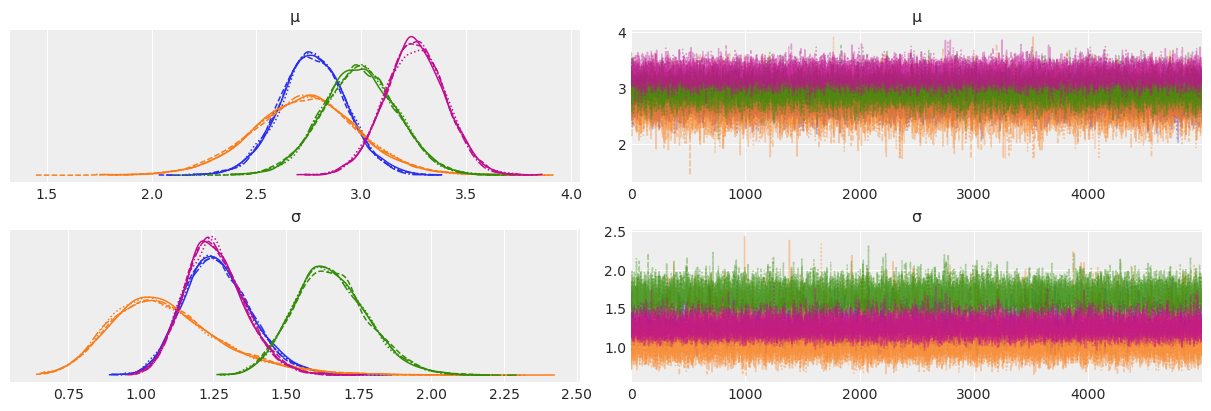

In [69]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)
    trace_cg = pm.sample(5000)
    
with comparing_groups:
    az.plot_trace(trace_cg)

with comparing_groups:
    trace_cg_sum = az.summary(trace_cg)
trace_cg_sum

In [70]:
# here is one share v per group
with pm.Model() as comparing_groups_out1:
    #hyperpriors
    #μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    #σ_μ = pm.HalfNormal('σ_μ', 10)
    
    #priors
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfCauchy('σ', 5, shape=groups)
    ν = pm.Exponential('ν', 1/30, shape=groups)
    
    y = pm.StudentT('y', mu=μ[idx], sd=σ[idx], nu=ν[idx], observed=tip)
    
    trace_cgo1 = pm.sample(5000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_13992/1280058184.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_cgo1 = pm.sample(5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 37 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


In [71]:
# here is one share v for all group
with pm.Model() as comparing_groups_out2:
    #hyperpriors
    #μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    #σ_μ = pm.HalfNormal('σ_μ', 10)
    
    #priors
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfCauchy('σ', 5, shape=groups)
    ν = pm.Exponential('ν', 1/30)
    
    y = pm.StudentT('y', mu=μ[idx], sd=σ[idx], nu=ν, observed=tip)
    
    trace_cgo2 = pm.sample(5000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_13992/94786186.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_cgo2 = pm.sample(5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 36 seconds.


D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>],
       [<AxesSubplot:title={'center':'ν'}>,
        <AxesSubplot:title={'center':'ν'}>]], dtype=object)

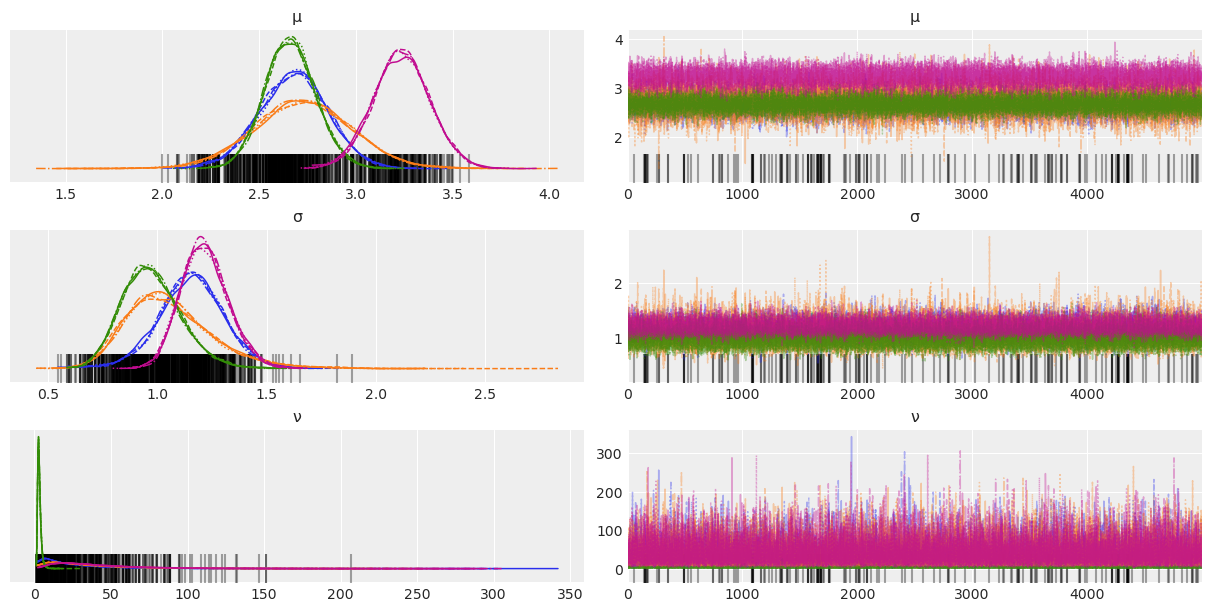

In [80]:
with comparing_groups_out1:
    az.plot_trace(trace_cgo1)

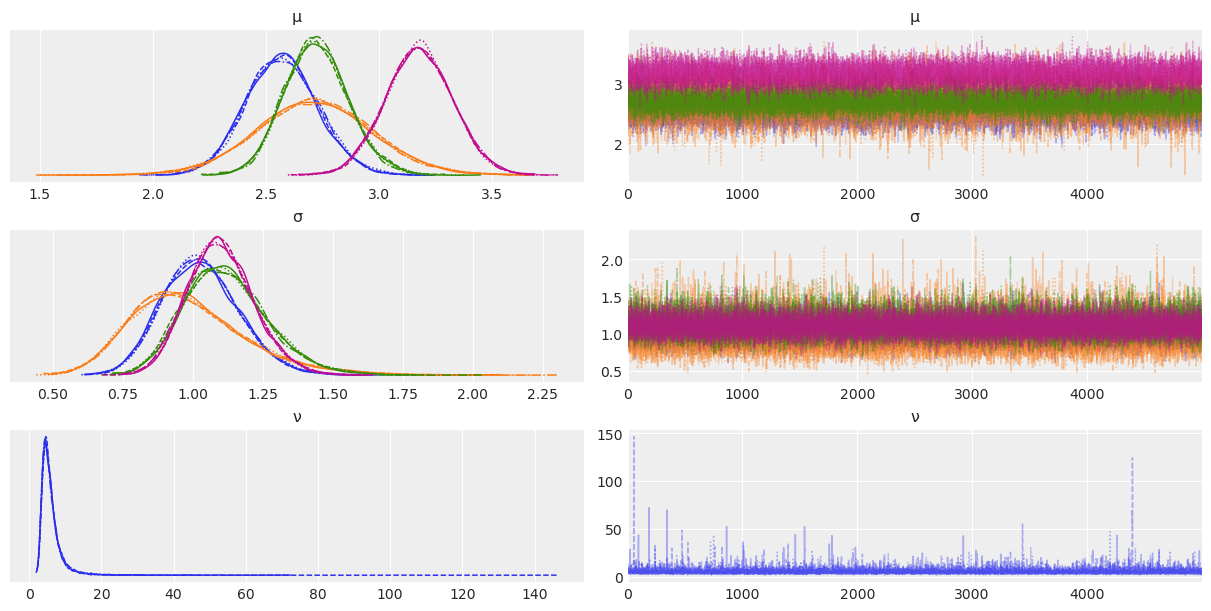

In [73]:
with comparing_groups_out2:
    az.plot_trace(trace_cgo2)

In [74]:
with comparing_groups_out1:
    trace_cgo1_sum = az.summary(trace_cgo1)
trace_cgo1_sum

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ[0]   2.677   0.178   2.336    3.004      0.002    0.001   11800.0    6002.0   
μ[1]   2.725   0.255   2.266    3.219      0.002    0.001   21847.0   12669.0   
μ[2]   2.661   0.132   2.412    2.910      0.001    0.001   22907.0   12769.0   
μ[3]   3.235   0.146   2.960    3.512      0.001    0.001   22927.0   12918.0   
σ[0]   1.155   0.152   0.864    1.440      0.002    0.001    9731.0    4522.0   
σ[1]   1.058   0.203   0.710    1.446      0.002    0.001   20766.0   13238.0   
σ[2]   0.973   0.135   0.725    1.227      0.001    0.001   18356.0   15387.0   
σ[3]   1.217   0.110   1.022    1.431      0.001    0.001   24214.0   14388.0   
ν[0]  27.697  27.204   1.215   77.475      0.198    0.142   10604.0    5051.0   
ν[1]  36.262  30.792   1.442   92.830      0.203    0.162   22279.0   12775.0   
ν[2]   3.193   1.280   1.417    5.294      0.011    0.008   18495.0   13052.0   
ν[3]  41.704  30.897   3.628   95.882      0.216    0.166   20884.0   14342.0   

      r_hat  
μ[0]    1.0  
μ[1]    1.0  
μ[2]    1.0  
μ[3]    1.0  
σ[0]    1.0  
σ[1]    1.0  
σ[2]    1.0  
σ[3]    1.0  
ν[0]    1.0  
ν[1]    1.0  
ν[2]    1.0  
ν[3]    1.0

In [75]:
with comparing_groups_out2:
    trace_cgo2_sum = az.summary(trace_cgo2)
trace_cgo2_sum

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ[0]  2.572  0.159   2.273    2.870      0.001    0.001   20380.0   15571.0   
μ[1]  2.714  0.259   2.228    3.210      0.002    0.001   21798.0   14151.0   
μ[2]  2.725  0.142   2.449    2.984      0.001    0.001   19779.0   14478.0   
μ[3]  3.179  0.148   2.896    3.452      0.001    0.001   22351.0   15278.0   
σ[0]  1.030  0.136   0.780    1.288      0.001    0.001   16613.0   14207.0   
σ[1]  0.988  0.210   0.629    1.391      0.001    0.001   21236.0   14381.0   
σ[2]  1.121  0.150   0.850    1.405      0.001    0.001   14681.0   12510.0   
σ[3]  1.101  0.119   0.877    1.320      0.001    0.001   18908.0   13696.0   
ν     5.959  3.553   2.434   10.499      0.040    0.029   12616.0   10168.0   

      r_hat  
μ[0]    1.0  
μ[1]    1.0  
μ[2]    1.0  
μ[3]    1.0  
σ[0]    1.0  
σ[1]    1.0  
σ[2]    1.0  
σ[3]    1.0  
ν       1.0

D:\Anaconda\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
No handles with labels found to put in legend.


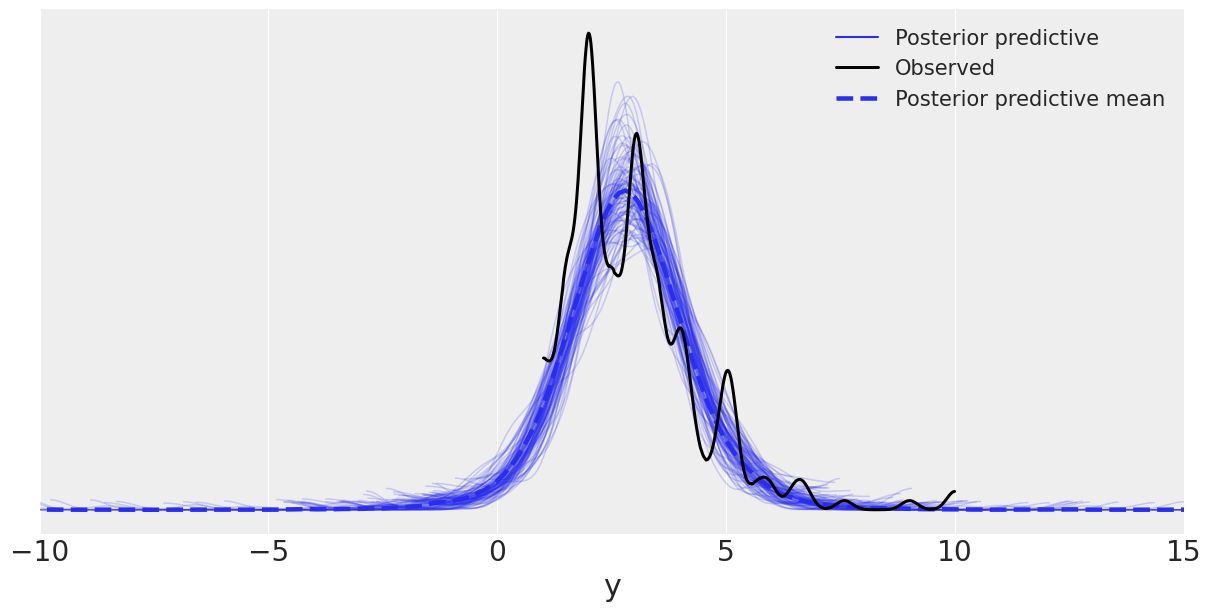

In [79]:
with comparing_groups_out1:
    ppc_cgo1 = pm.sample_posterior_predictive(trace_cgo1,  100, comparing_groups_out1, random_seed=123)
    ppc_cgo1_in = az.from_pymc3(trace=trace_cgo1, posterior_predictive = ppc_cgo1 )
    az.plot_ppc(ppc_cgo1_in, figsize=(12,6))
    ax[0].legend(fontsize=15)
    plt.xlim(-10, 15)
    

array([[<AxesSubplot:title={'center':'μ\n0'}>,
        <AxesSubplot:title={'center':'μ\n1'}>,
        <AxesSubplot:title={'center':'μ\n2'}>],
       [<AxesSubplot:title={'center':'μ\n3'}>,
        <AxesSubplot:title={'center':'σ\n0'}>,
        <AxesSubplot:title={'center':'σ\n1'}>],
       [<AxesSubplot:title={'center':'σ\n2'}>,
        <AxesSubplot:title={'center':'σ\n3'}>,
        <AxesSubplot:title={'center':'ν\n0'}>],
       [<AxesSubplot:title={'center':'ν\n1'}>,
        <AxesSubplot:title={'center':'ν\n2'}>,
        <AxesSubplot:title={'center':'ν\n3'}>]], dtype=object)

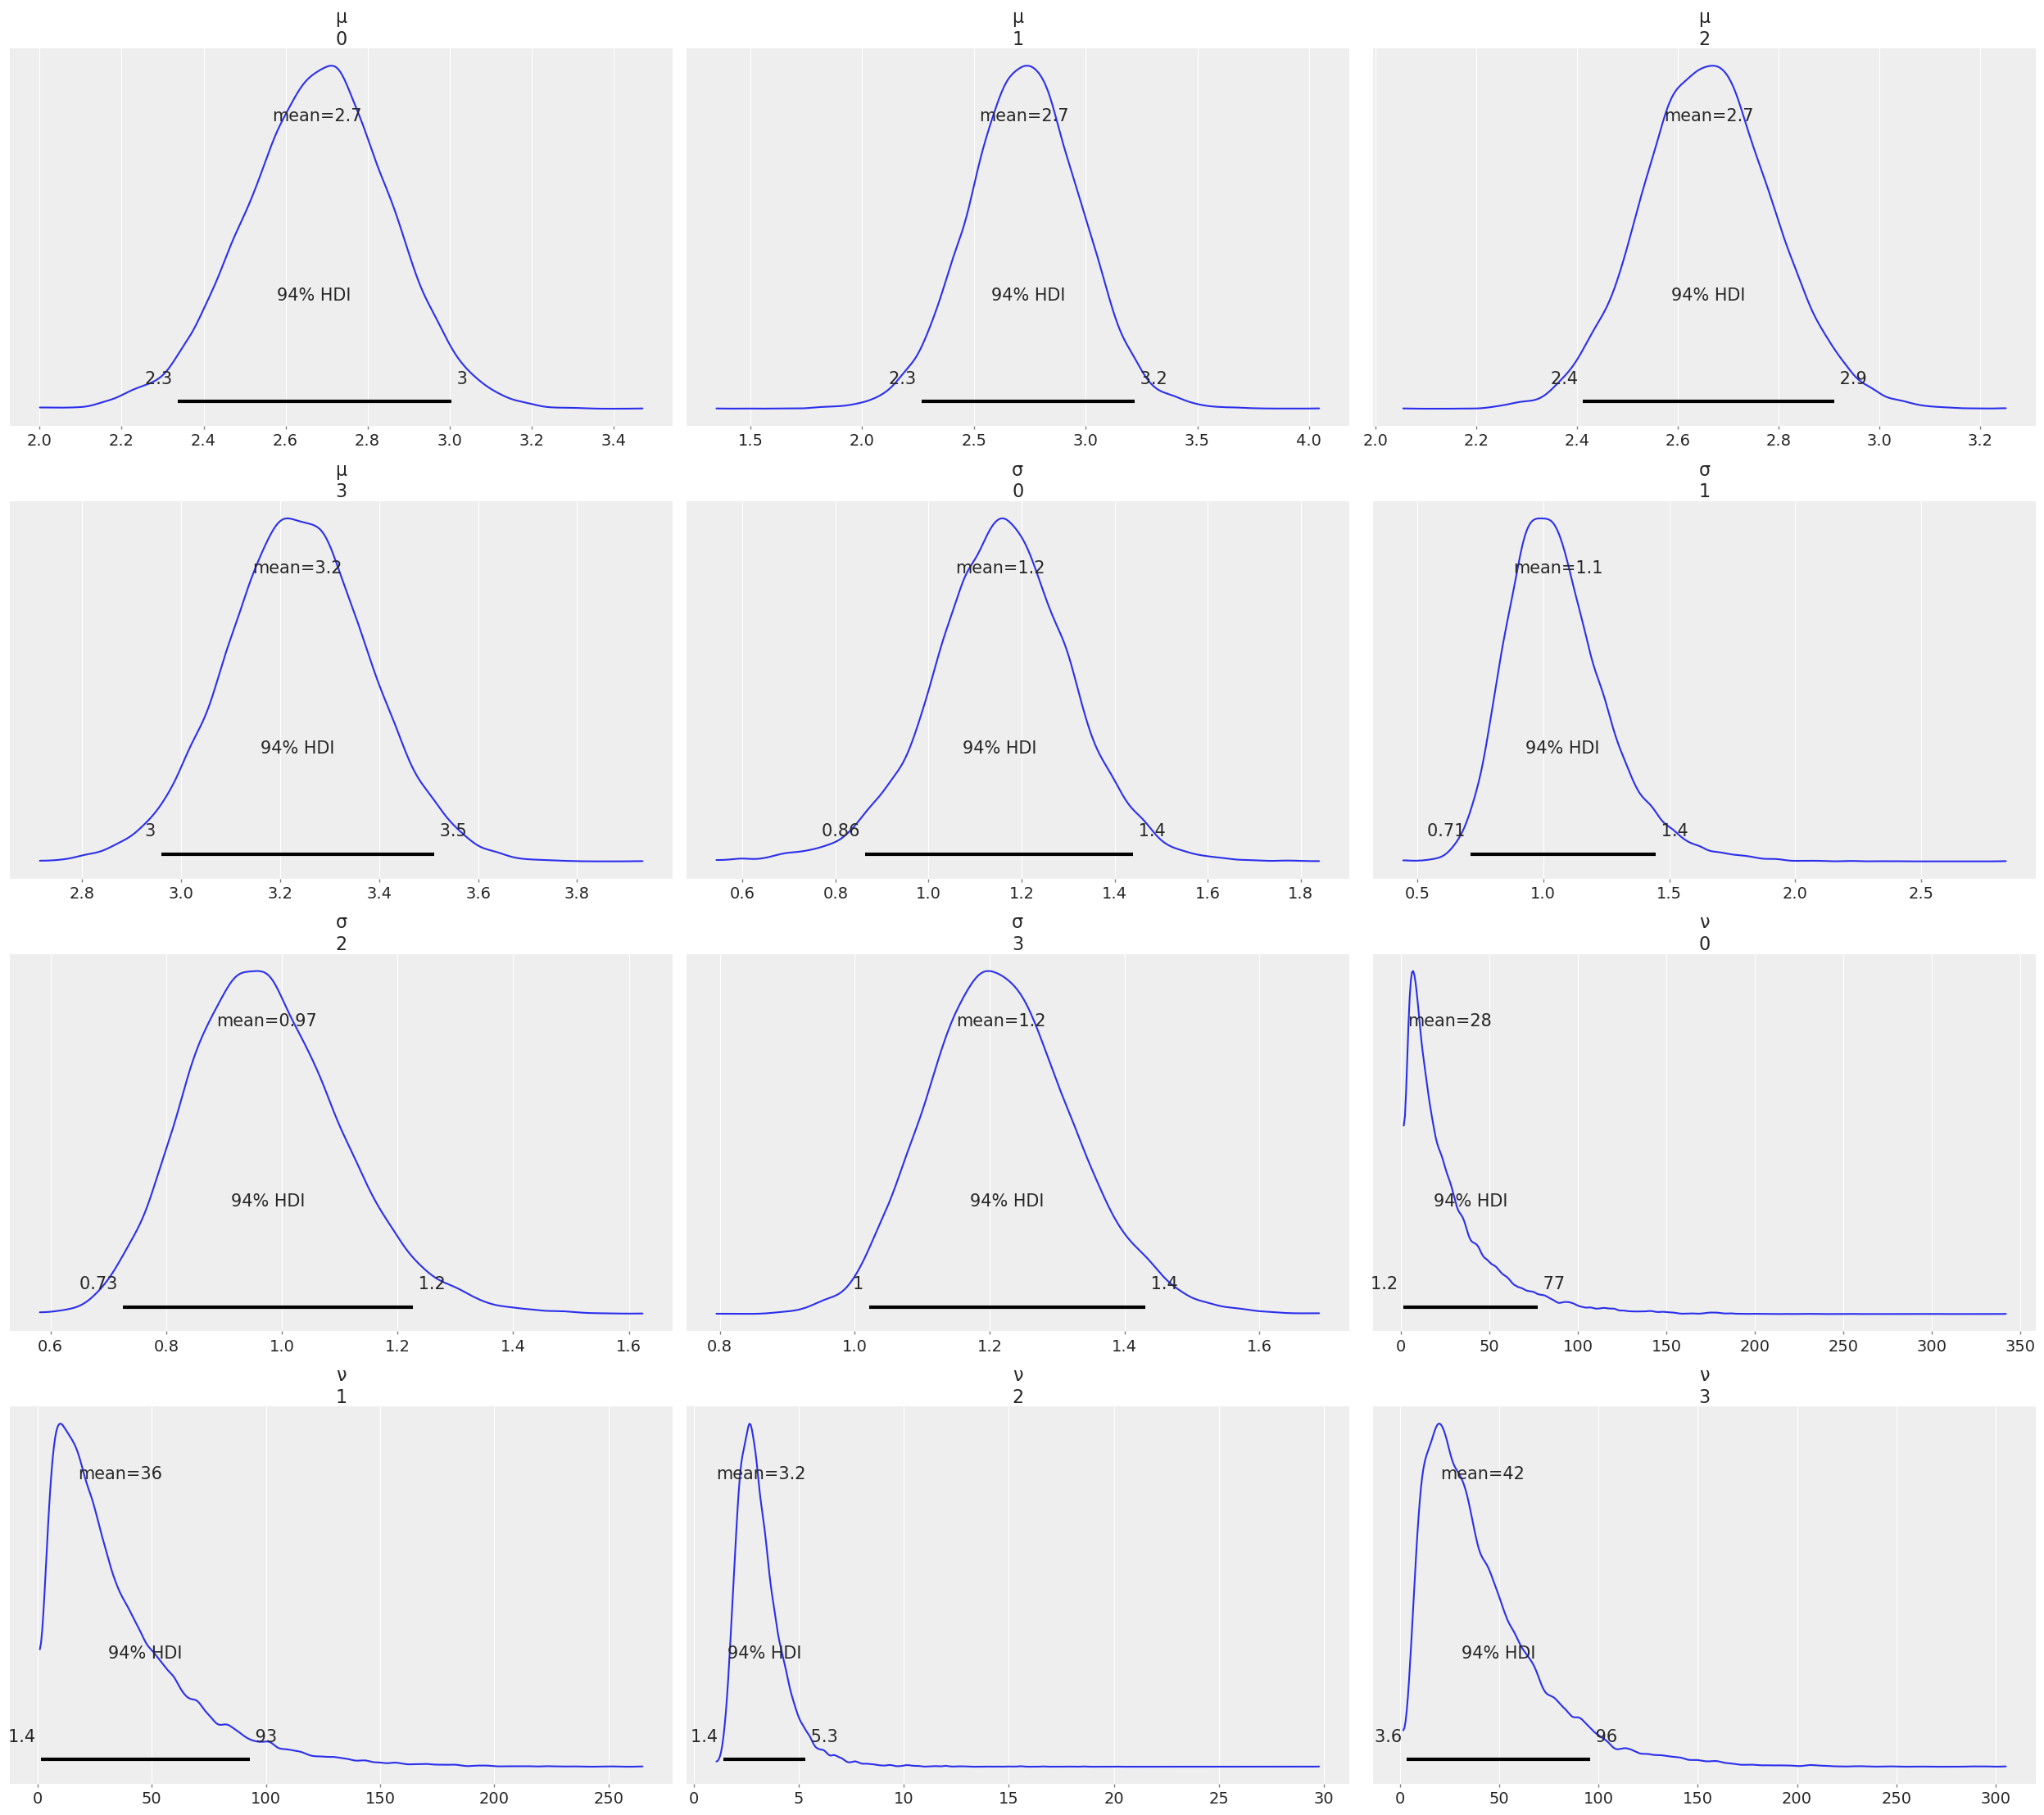

In [83]:
az.plot_posterior(ppc_cgo1_in , var_names=["μ", "σ", "ν"], kind='kde')

In [84]:
help(az.plot_ppc)

Help on function plot_ppc in module arviz.plots.ppcplot:

plot_ppc(data, kind='kde', alpha=None, mean=True, observed=True, color='C0', grid=None, figsize=None, textsize=None, data_pairs=None, var_names=None, filter_vars=None, coords=None, flatten=None, flatten_pp=None, num_pp_samples=None, random_seed=None, jitter=None, animated=False, animation_kwargs=None, legend=True, ax=None, backend=None, backend_kwargs=None, group='posterior', show=None)
    Plot for posterior/prior predictive checks.
    
    Parameters
    ----------
    data: az.InferenceData object
        InferenceData object containing the observed and posterior/prior predictive data.
    kind: str
        Type of plot to display (kde, cumulative, or scatter). Defaults to kde.
    alpha: float
        Opacity of posterior/prior predictive density curves.
        Defaults to 0.2 for kind = kde and cumulative, for scatter defaults to 0.7
    mean: bool
        Whether or not to plot the mean posterior/prior predictive distrib

# Exercise 6

# Exercise 7

Repeat the exercise we did with model_h. This time, without hierarchical structure, use a flat prior such as \mathbf{Beta}(\alpha =1, \beta =1). Compare the results of both models.

In [25]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]- G_samples[i]]))

In [26]:
with pm.Model() as model_wh:
    #μ = pm.Beta('μ', 1., 1.)
    #κ = pm.HalfNormal('κ', 10)
    θ = pm.Beta('θ', alpha=1., beta=1., shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
    trace_wh = pm.sample(2000)


C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_13992/1099030230.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_wh = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 99 seconds.


D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

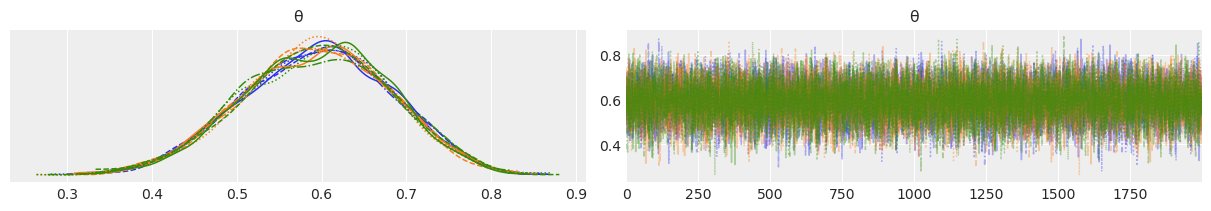

In [27]:
az.plot_trace(trace_wh)

D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


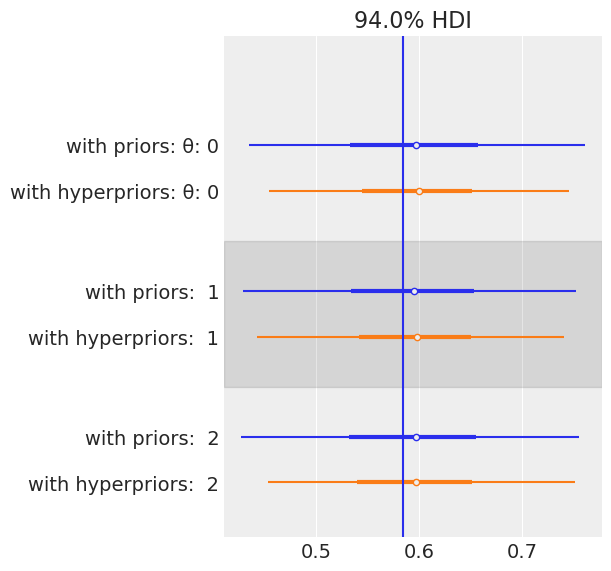

In [46]:
ax = az.plot_forest([trace_wh, trace_h], model_names=['with priors', 'with hyperpriors'],
                    var_names = ['θ'], combined=True, colors = 'cycle')
y_lims = ax[0].get_ylim()
a, b = trace_h['μ'].mean() * trace_h['κ'].mean() , (1.0-trace_h['μ'].mean()) * trace_h['κ'].mean()
mean = stats.beta.stats(a, b, moments='m')
ax[0].vlines(mean, *y_lims)
#ax[0].vlines((1.0-trace_h['μ'].mean()) * trace_h['κ'].mean(), *y_lims)

In [30]:
with model_wh:
    model_wh_sum=az.summary(trace_wh)
model_wh_sum

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
θ[0]  0.594  0.088   0.435    0.761      0.001    0.001    9847.0    5954.0   
θ[1]  0.593  0.087   0.429    0.752      0.001    0.001   10647.0    6099.0   
θ[2]  0.593  0.088   0.427    0.755      0.001    0.001    9861.0    6009.0   

      r_hat  
θ[0]    1.0  
θ[1]    1.0  
θ[2]    1.0

In [31]:
with model_h:
    model_h_sum=az.summary(trace_h)
model_h_sum

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ      0.584  0.095   0.397    0.755      0.001    0.001    5555.0    5282.0   
κ     12.276  6.133   1.872   23.360      0.078    0.055    5708.0    4952.0   
θ[0]   0.597  0.079   0.454    0.746      0.001    0.001    5803.0    5759.0   
θ[1]   0.595  0.079   0.443    0.740      0.001    0.001    6069.0    5543.0   
θ[2]   0.595  0.080   0.453    0.751      0.001    0.001    6114.0    5778.0   

      r_hat  
μ       1.0  
κ       1.0  
θ[0]    1.0  
θ[1]    1.0  
θ[2]    1.0

In [34]:
help(stats.beta)

Help on beta_gen in module scipy.stats._continuous_distns:

<scipy.stats._continuous_distns.beta_gen object>
    A beta continuous random variable.
    
    As an instance of the `rv_continuous` class, `beta` object inherits from it
    a collection of generic methods (see below for the full list),
    and completes them with details specific for this particular distribution.
    
    Methods
    -------
    rvs(a, b, loc=0, scale=1, size=1, random_state=None)
        Random variates.
    pdf(x, a, b, loc=0, scale=1)
        Probability density function.
    logpdf(x, a, b, loc=0, scale=1)
        Log of the probability density function.
    cdf(x, a, b, loc=0, scale=1)
        Cumulative distribution function.
    logcdf(x, a, b, loc=0, scale=1)
        Log of the cumulative distribution function.
    sf(x, a, b, loc=0, scale=1)
        Survival function  (also defined as ``1 - cdf``, but `sf` is sometimes more accurate).
    logsf(x, a, b, loc=0, scale=1)
        Log of the survival 

In [36]:
a, b = 7.1691, 5.10681
mean, var, skew, kurt = stats.beta.stats(a, b, moments='mvsk')

# Exercise 8

Create a hierarchical version of the tips example by partially pooling across the days of the week. Compare the results to those obtained without the hierarchical structure.

In [12]:
# tips is data on restaurant
# we are interested with the effect of day (groups) on the amount of tips (pourboire)
tips = pd.read_csv('C:/Users/kamguia_l/Documents/data/tips.csv')
tips.tail()

total_bill   tip     sex smoker   day    time  size
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

<AxesSubplot:xlabel='day', ylabel='tip'>

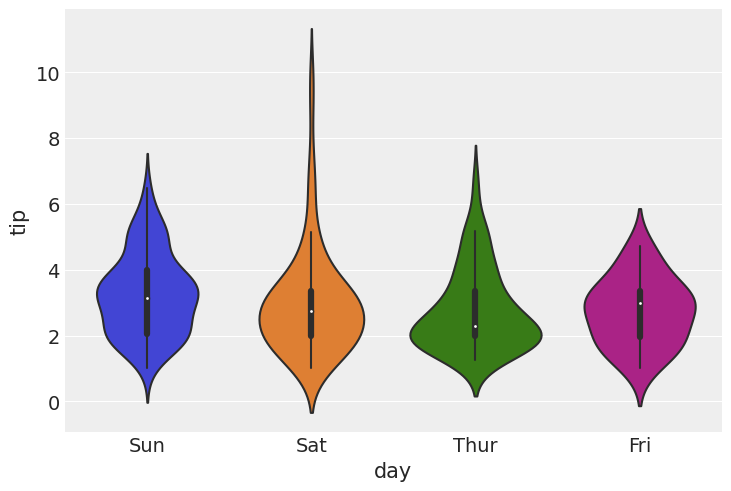

In [13]:
sns.violinplot(x='day', y='tip', data=tips)

In [14]:
tip = tips['tip'].values #produce an array that contain all data (value) of tip
idx = pd.Categorical(tips['day'], categories=['Thur', 'Fri', 'Sat', 'Sun']).codes # an array with the category as value
groups = len(np.unique(idx)) # contains the scalar 4 for 4 groups

In [16]:
with pm.Model() as comparing_groups_hier:
    #hyperpriors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)
    
    #priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfCauchy('σ', 5, shape=groups)
    
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)
    
    trace_cgh = pm.sample(5000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_13992/1244081406.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_cgh = pm.sample(5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ, σ_μ, μ_μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 112 seconds.
There were 756 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7055169662953025, but should be close to 0.8. Try to increase the number of tuning steps.
There were 686 divergences after tuning. Increase `target_accept` or reparameterize.
There were 312 divergences after tuning. Increase `target_accept` or reparameterize.
There were 338 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


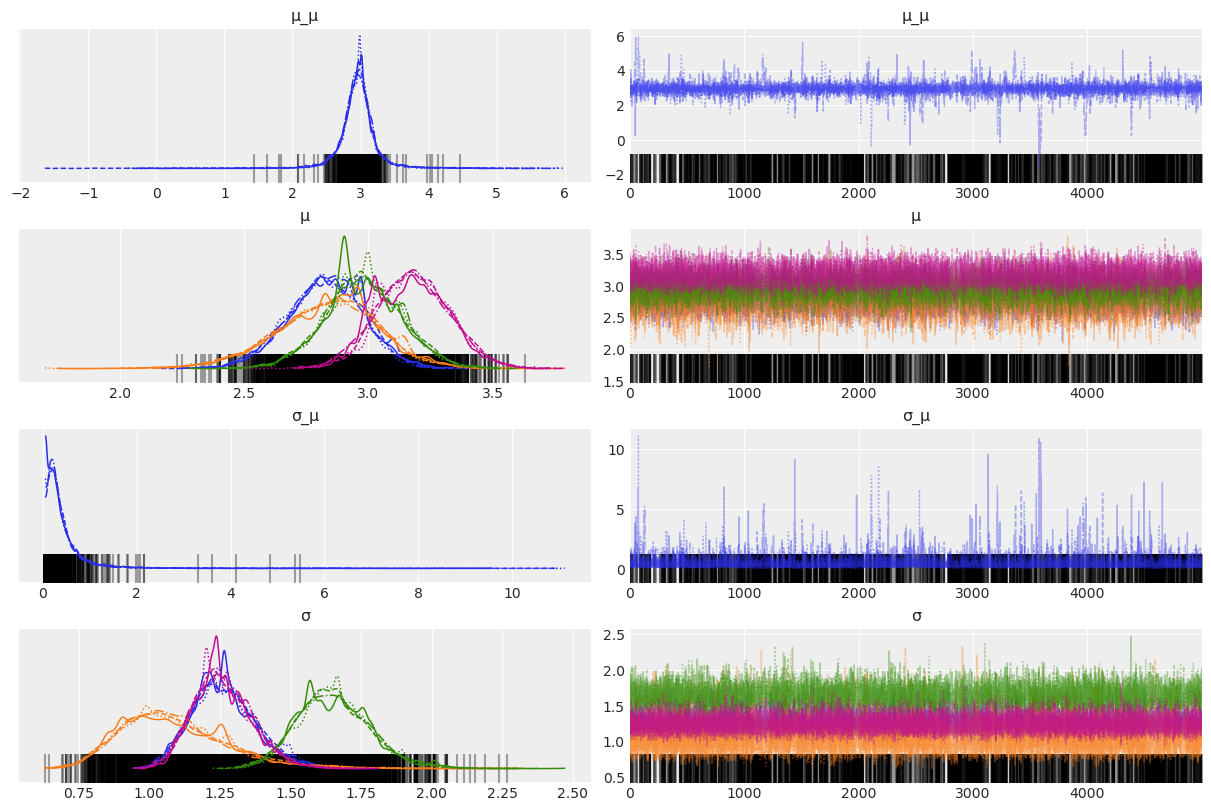

In [17]:
with comparing_groups_hier:
    az.plot_trace(trace_cgh)
plt.savefig('B11197_02_40.png', dpi=300)

D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


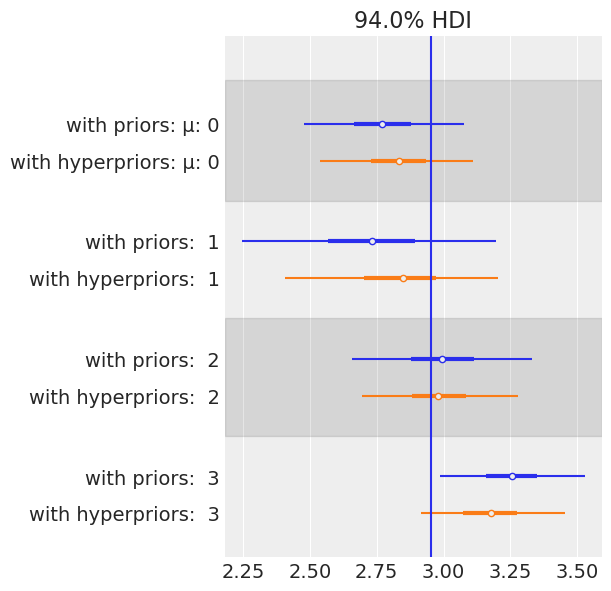

In [18]:
ax = az.plot_forest([trace_cg, trace_cgh], model_names=['with priors', 'with hyperpriors'],
                    var_names = 'μ', combined=True, colors = 'cycle')
y_lims = ax[0].get_ylim()
ax[0].vlines(trace_cgh['μ_μ'].mean(), *y_lims)

# Exercise 9

In [121]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Programmes/Graphviz/bin'

In [108]:
model_gm

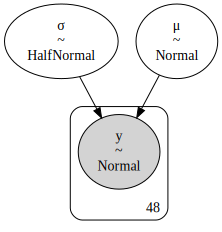

In [109]:
pm.model_to_graphviz(model_gm)

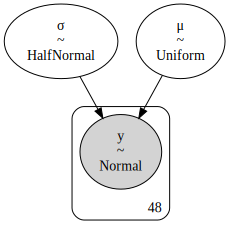

In [110]:
pm.model_to_graphviz(model_g)

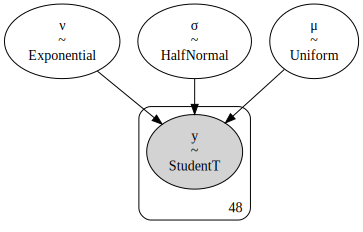

In [111]:
pm.model_to_graphviz(model_t)

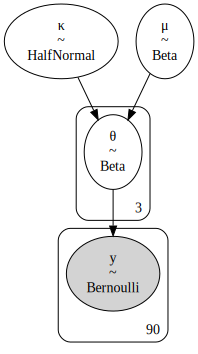

In [112]:
pm.model_to_graphviz(model_h)

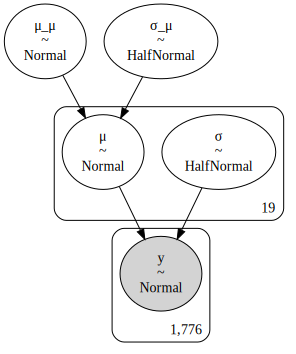

In [113]:
pm.model_to_graphviz(cs_h)

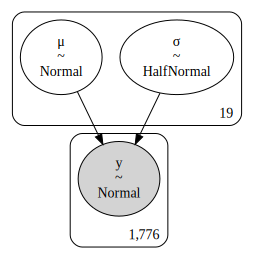

In [114]:
pm.model_to_graphviz(cs_nh)

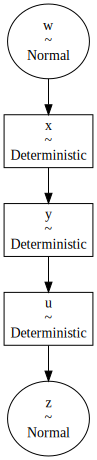

In [115]:
with pm.Model() as model:
    w = pm.Normal('w')
    x = pm.Deterministic('x', w)
    y = pm.Deterministic('y', x)
    u = pm.Deterministic('u', y)
    z = pm.Normal('z', u)
pm.model_to_graphviz(model)

In [5]:
import pymc3 as pm

In [116]:
!pip3 install nbconvert

In [118]:
import os
os.environ['PATH'].split(';')

['D:\\Anaconda',
 'D:\\Anaconda\\Library\\mingw-w64\\bin',
 'D:\\Anaconda\\Library\\usr\\bin',
 'D:\\Anaconda\\Library\\bin',
 'D:\\Anaconda\\Scripts',
 'C:\\Program Files\\Microsoft MPI\\Bin\\',
 'C:\\ActiveTcl\\bin',
 'C:\\Users\\kamguia_l\\Anaconda3\\',
 'C:\\Program Files (x86)\\Common Files\\Oracle\\Java\\javapath',
 'C:\\Users\\kamguia_l\\AppData\\Local\\r-miniconda\\',
 'C:\\Users\\kamguia_l\\AppData\\Local\\r-miniconda\\envs\\r-reticulate\\',
 'C:\\Users\\kamguia_l\\AppData\\Local\\Programs\\Python\\Python38\\Scripts',
 'C:\\WINDOWS\\system32',
 'C:\\WINDOWS',
 'C:\\WINDOWS\\System32\\Wbem',
 'C:\\WINDOWS\\System32\\WindowsPowerShell\\v1.0\\',
 'C:\\WINDOWS\\System32\\OpenSSH\\',
 'C:\\Program Files\\Intel\\WiFi\\bin\\',
 'C:\\Program Files\\Common Files\\Intel\\WirelessCommon\\',
 'C:\\Program Files\\R\\R-3.6.2\\bin',
 'C:\\Rtools\\bin',
 'C:\\Rtools\\mingw_64\\bin',
 'C:\\oracle\\instantclient_19_5',
 'C:\\oracle\\instantclient_19_5\\ODAC',
 'C:\\oracle\\bin',
 'C:\\oracle\\i